<a href="https://colab.research.google.com/github/BianchiLuca28/FHNW-BI-LMS/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Overview
- Predictive model to determine "service_type" for shipments by a B2B company using third-party carriers.
- Dataset includes details like customer pricing, carrier pricing, shipment weights, and delivery locations.
- Objective: Predict service type using machine learning to support operational and strategic business decisions.

## Business Motivation
- **Operational Efficiency**: Optimize logistics and resource allocation.
- **Cost Savings**: Identify cost reduction opportunities.
- **Customer Experience**: Offer tailored services for different customer needs.
- **Strategic Insights**: Analyze profitability and trends across service types to enhance business planning.

## Data Analysis and Preprocessing
- **EDA**: Explored feature distributions, identified outliers, and evaluated class imbalances.
- **Preprocessing**: Included feature selection, encoding, outlier removal, and margin estimation.

## Modeling Process
- **Handling Imbalanced Data**: Addressed class imbalances with SMOTE for underrepresented service types.
- **"Special" Class Reassessment**: Previously thought to have insufficient samples, further analysis revealed adequate representation in the dataset.
- This allowed inclusion of the "Special" class in the modeling process, with successful handling through SMOTE for training, which was one of the most important classes for the client.
- **Feature Selection** considering only the most important features and the ones that are available during the prediction.

## Model Selection and Evaluation
- **Algorithms**: Evaluated multiple models including Logistic Regression, Naive Bayes, Decision Tree, Random Forest, XGBoost, and LightGBM.
- **Metrics**: Used metrics such as Accuracy, ROC AUC, and detailed classification reports.
- **Final Model**: Random Forest selected for its robust performance, achieving a Test Set Accuracy of 0.9758.

## Conclusion
- The model effectively predicts all service types.
- Provides actionable insights for operational decision-making and improving business efficiency.
- Enables the company to optimize its logistics, reduce costs, and enhance customer satisfaction.
- Having reached such high performance, it is clear that the dataset can indeed undercover some **important pattern** to predict the customer behavior.
- The cost matrix analysis revealed a total cost of 1120, primarily driven by false negatives (1100), reflecting the high impact of missing critical service type predictions. False positives contributed a smaller cost (20), aligning with the business priority of minimizing operational failures over minor inefficiencies. This highlights the importance of optimizing the model to reduce false negatives for greater business value.

# Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data preprocessing and utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)

# Oversampling
from imblearn.over_sampling import SMOTE

# Statistical tools
from scipy import stats

# Importing dataset

Importing the dataset from the online source in Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Change with your location to read the dataset from
folder_path = "/content/drive/MyDrive/__Shared/BI"

In [4]:
df = pd.read_csv(folder_path + "/preprocessed_flattened_dataset.csv")

<ipython-input-4-da48d673589e>:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder_path + "/preprocessed_flattened_dataset.csv")


In [2]:
# When working locally
df = pd.read_csv("../../00-Project/datasets/preprocessed_flattened_dataset.csv")

/tmp/ipykernel_267168/2340058143.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../00-Project/datasets/preprocessed_flattened_dataset.csv")


# Exploratory Data Analysis (EDA)

Exploring the dataset with various analysis, without performing any kind of preprocessing.

In here we analyze:
- Basic data visualization.
- Check duplicates.
- Missing values.
- Correlations.
- Distributions.
- Outliers.
- The target variable "service_type".
- Feature importance.




## Basic Data Exploration

In [5]:
# Basic Data Overview
print("Dataset Overview:")
display(df.head())

# Summary statistics for numerical features
print("\nSummary Statistics:")
display(df.describe())

# Data types and missing value counts
print("\nData Types and Missing Values:")
print(df.dtypes)
print("\nMissing Values Count:")
print(df.isnull().sum())

Dataset Overview:


shipment_id  customer_price  expected_carrier_price  final_carrier_price  \
0      4499940            8.64                    5.92                 4.96   
1      4505367           19.24                   10.93                 8.47   
2      4525434            0.00                    0.00                 0.00   
3      4536217           19.16                   10.89                 8.46   
4      4537360            0.00                    0.00                 0.00   

   weight shipment_type insurance_type  customer_id domain_name  \
0     1.5        Parcel   No_Insurance      20378.0          DE   
1    18.0        Parcel   No_Insurance      80847.0          DE   
2     6.0        Parcel   No_Insurance         60.0          DE   
3    18.0        Parcel   No_Insurance      80847.0          DE   
4     8.0        Parcel   No_Insurance       8711.0          DE   

   booking_state  ...  quarter_pickup_date  year_delivery_date  \
0             12  ...                  1.0              2022.0   
1             12  ...                  1.0              2022.0   
2             12  ...                  1.0                 NaN   
3             12  ...                  1.0              2022.0   
4             12  ...                  1.0                 NaN   

   month_delivery_date quarter_delivery_date year_real_pickup_date  \
0                 11.0                   4.0                2023.0   
1                 12.0                   4.0                2023.0   
2                  NaN                   NaN                   NaN   
3                 12.0                   4.0                2023.0   
4                  NaN                   NaN                   NaN   

  month_real_pickup_date  quarter_real_pickup_date  year_real_delivery_date  \
0                    1.0                       1.0                   2023.0   
1                    1.0                       1.0                   2023.0   
2                    NaN                       NaN                      NaN   
3                    1.0                       1.0                   2023.0   
4                    NaN                       NaN                      NaN   

   month_real_delivery_date quarter_real_delivery_date  
0                       1.0                        1.0  
1                       1.0                        1.0  
2                       NaN                        NaN  
3                       1.0                        1.0  
4                       NaN                        NaN  

[5 rows x 52 columns]


Summary Statistics:


shipment_id  customer_price  expected_carrier_price  \
count  7.114580e+05   711458.000000           711458.000000   
mean   4.950453e+06       49.312259               32.165451   
std    2.196774e+05      131.276157               94.469734   
min    4.473042e+06      -24.210000             -119.930000   
25%    4.760020e+06        9.640000                6.680000   
50%    4.950118e+06       20.370000               13.290000   
75%    5.140535e+06       46.980000               29.190000   
max    5.768367e+06    27450.000000            26238.000000   

       final_carrier_price         weight    customer_id  booking_state  \
count        571302.000000  711178.000000  711178.000000  711458.000000   
mean             30.498302      12.934943   77649.081254      12.282812   
std              91.488247     122.053645   51004.174026       1.377811   
min            -118.260000       0.000000       1.000000       7.000000   
25%               8.230000       1.190000   33531.000000      12.000000   
50%              13.650000       3.500000   68443.000000      12.000000   
75%              28.500000      11.000000  124051.000000      12.000000   
max           26238.000000   70036.000000  177551.000000      19.000000   

            lms_plus     exworks_id         margin  ...  quarter_pickup_date  \
count  711178.000000   28017.000000  571302.000000  ...        711458.000000   
mean        0.139183  177457.483171      21.266080  ...             2.493325   
std         0.346138   14311.842355      53.835062  ...             1.122960   
min         0.000000  153422.000000   -1848.390000  ...             1.000000   
25%         0.000000  164759.000000       3.420000  ...             1.000000   
50%         0.000000  176850.000000       7.820000  ...             2.000000   
75%         0.000000  189780.000000      20.260000  ...             4.000000   
max         1.000000  203057.000000    4070.000000  ...             4.000000   

       year_delivery_date  month_delivery_date  quarter_delivery_date  \
count       549896.000000        549896.000000          549896.000000   
mean          2023.001868             6.573307               2.514108   
std              0.044585             3.435033               1.123319   
min           2022.000000             1.000000               1.000000   
25%           2023.000000             4.000000               2.000000   
50%           2023.000000             7.000000               3.000000   
75%           2023.000000            10.000000               4.000000   
max           2024.000000            12.000000               4.000000   

       year_real_pickup_date  month_real_pickup_date  \
count          663932.000000           663932.000000   
mean             2023.001901                6.492677   
std                 0.097809                3.430977   
min              1970.000000                1.000000   
25%              2023.000000                3.000000   
50%              2023.000000                6.000000   
75%              2023.000000               10.000000   
max              2025.000000               12.000000   

       quarter_real_pickup_date  year_real_delivery_date  \
count             663932.000000            657900.000000   
mean                   2.491434              2023.007095   
std                    1.122163                 0.207662   
min                    1.000000              2022.000000   
25%                    1.000000              2023.000000   
50%                    2.000000              2023.000000   
75%                    4.000000              2023.000000   
max                    4.000000              2138.000000   

       month_real_delivery_date  quarter_real_delivery_date  
count             657900.000000               657900.000000  
mean                   6.531073                    2.501973  
std                    3.431963                    1.122624  
min                    1.000000                    1.000000  
25%                    3.0000


Data Types and Missing Values:
shipment_id                        int64
customer_price                   float64
expected_carrier_price           float64
final_carrier_price              float64
weight                           float64
shipment_type                     object
insurance_type                    object
customer_id                      float64
domain_name                       object
booking_state                      int64
lms_plus                         float64
exworks_id                       float64
margin                           float64
domain_name_customer              object
main_industry_name_customer       object
industry_sector_name_customer     object
segmentation_customer            float64
sequence_number_customer         float64
structure_number_customer        float64
is_master_customer                object
domain_name_delivery              object
postal_code_delivery              object
city_delivery                     object
name_country_delivery    

## Duplicates Analysis

From the analysis we can see that there are no duplicates.

In [6]:
# Check for duplicate rows in the dataset
duplicates = df[df.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows: {duplicates.shape[0]}")

# Optionally, display the duplicate rows
if not duplicates.empty:
    print("Duplicate rows:")
    print(duplicates)

Number of duplicate rows: 0


## Missing Values Analysis

Some columns have too many null values to be treated.

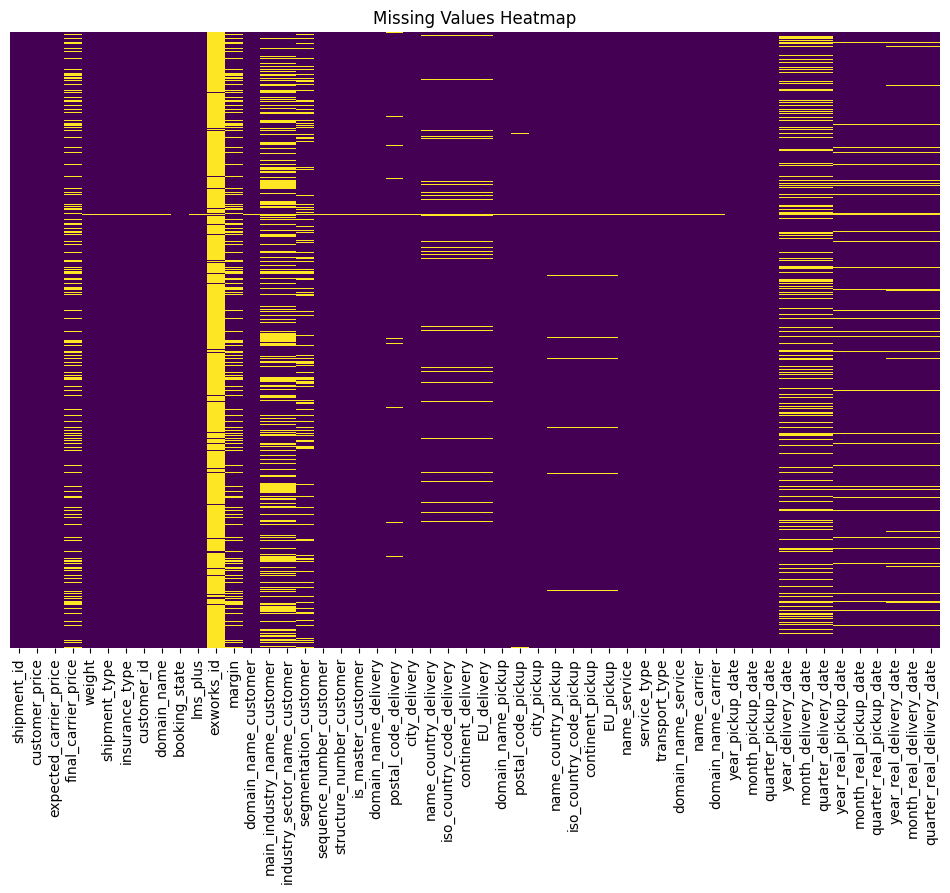

In [7]:
# Heatmap to visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

## Correlation Heatmap for Numerical Features

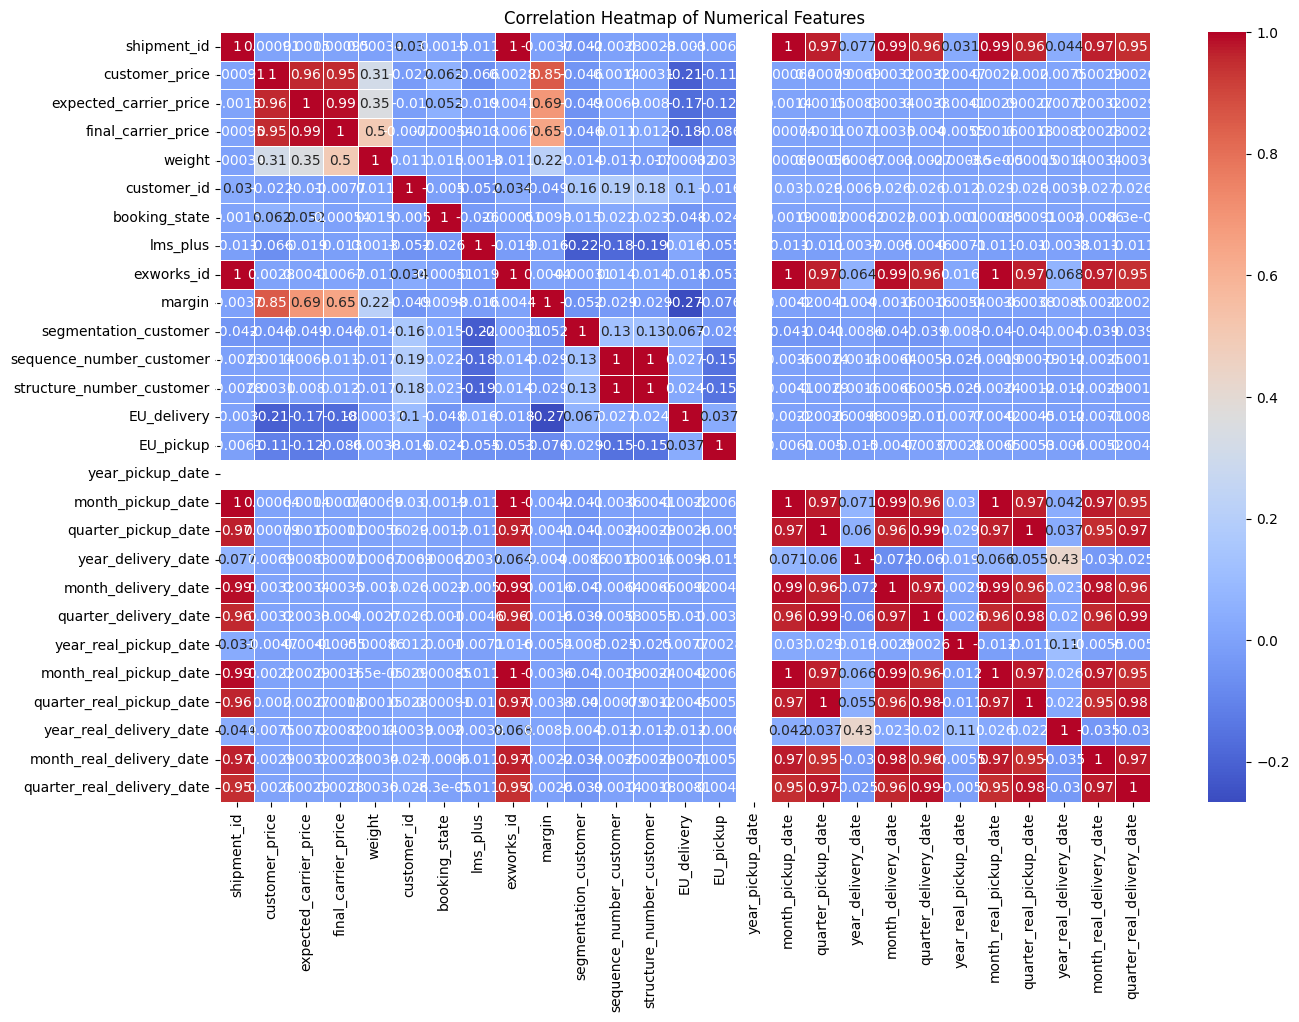

In [8]:
# Select only numerical columns
numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap for numerical features
plt.figure(figsize=(15, 10))
corr_matrix = numerical_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

## Visualizing Feature Distributions

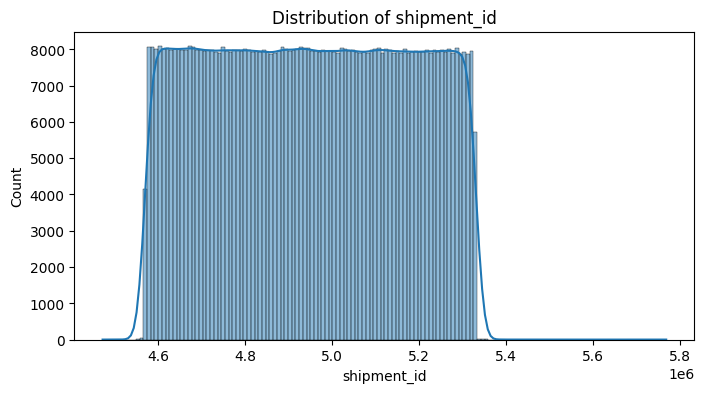

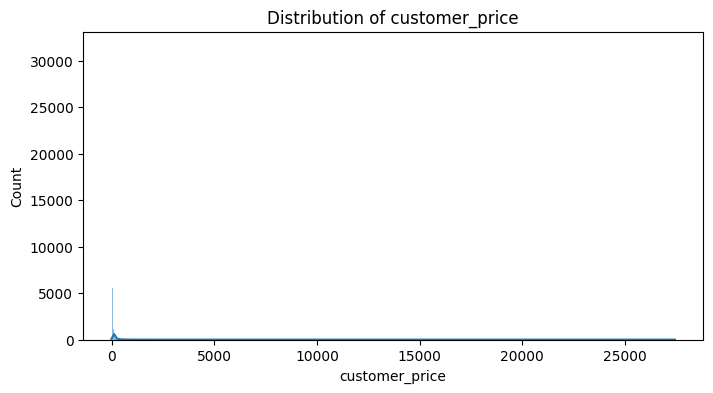

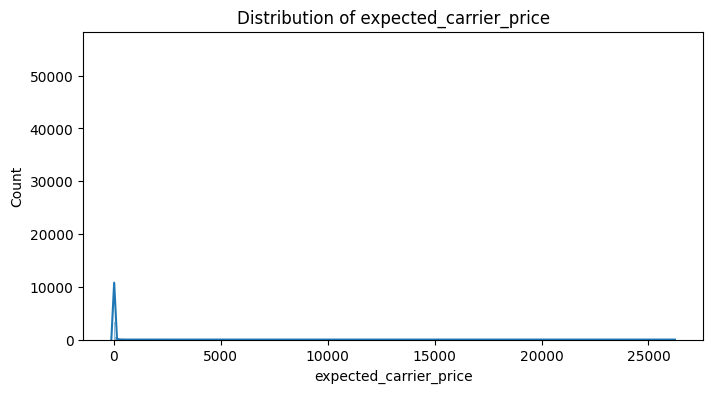

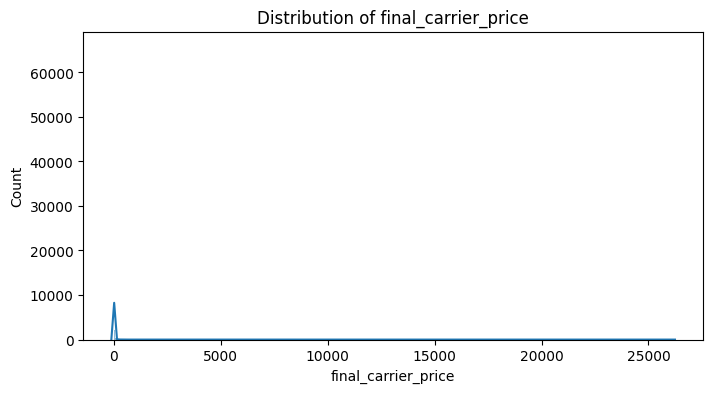

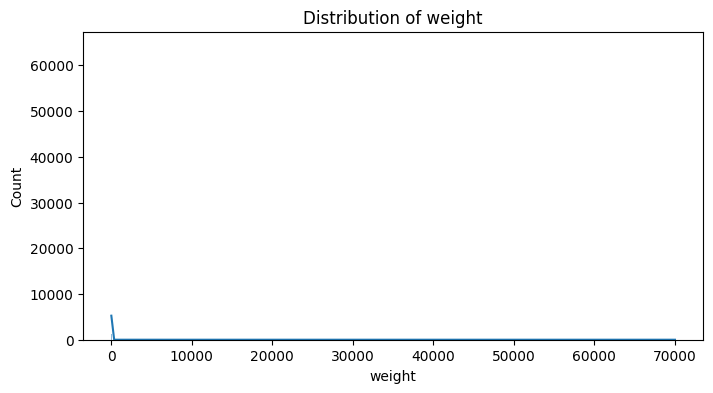

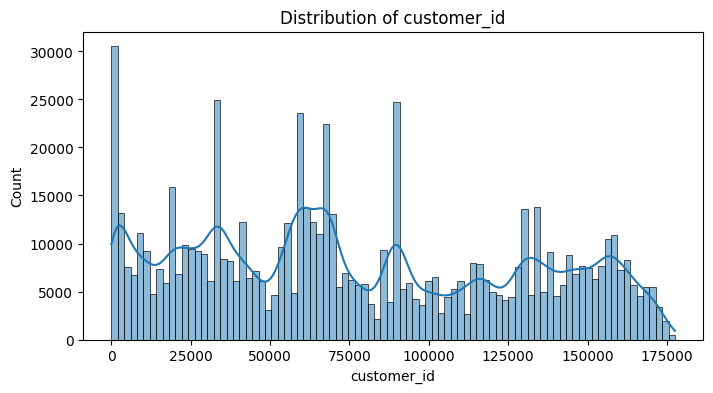

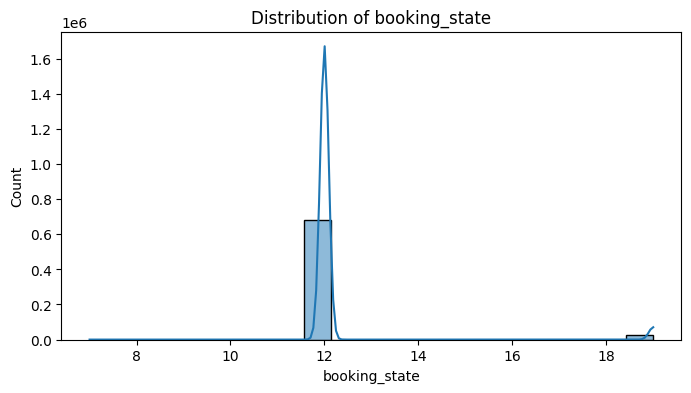

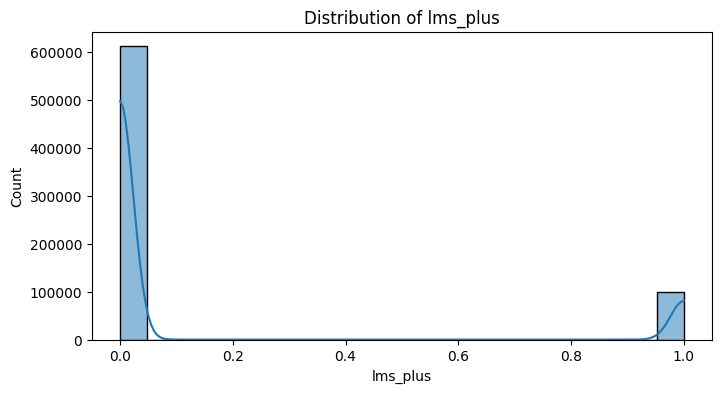

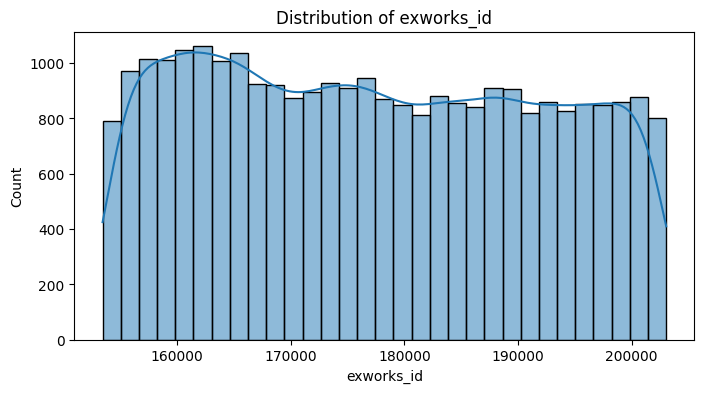

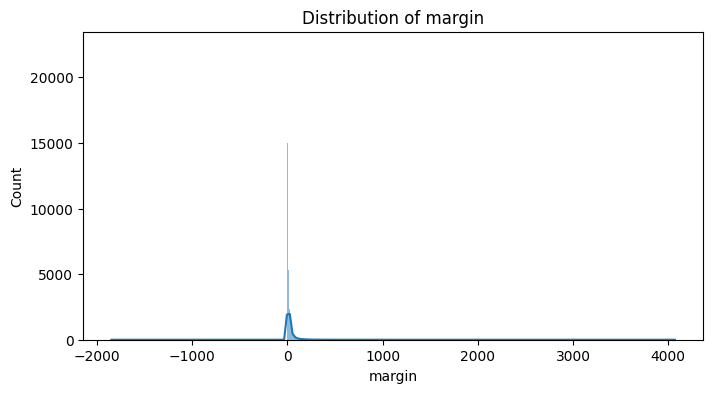

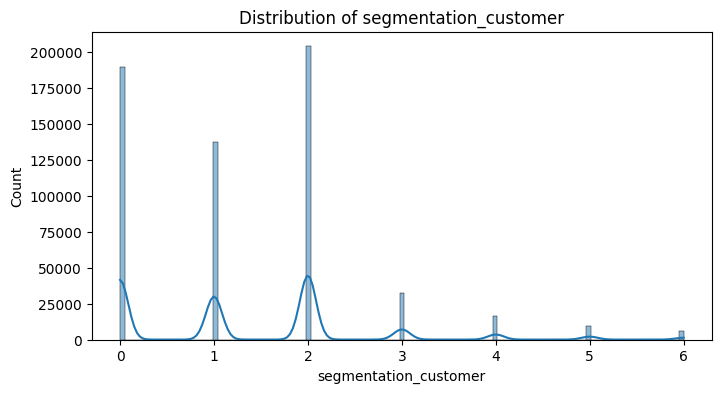

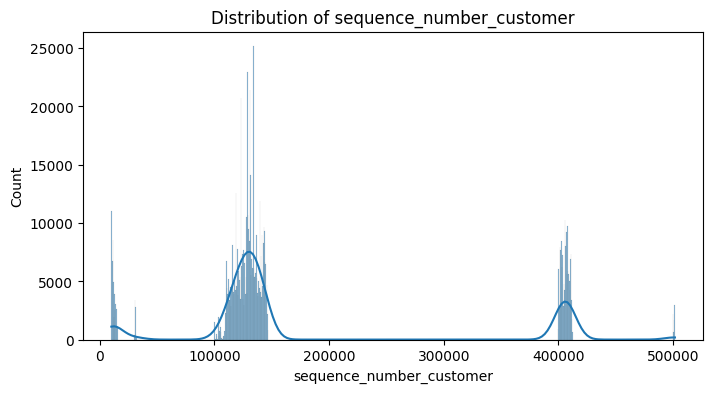

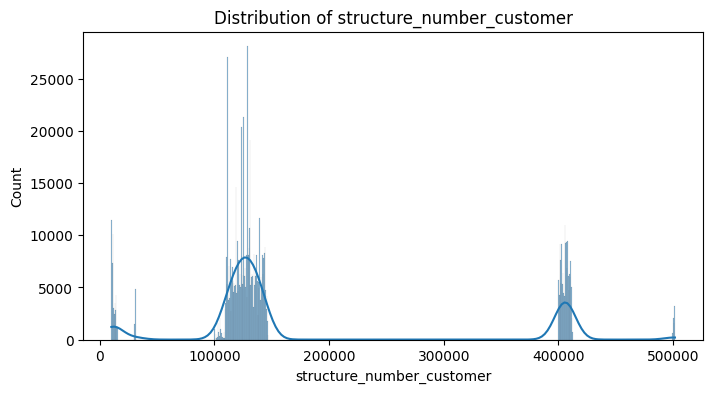

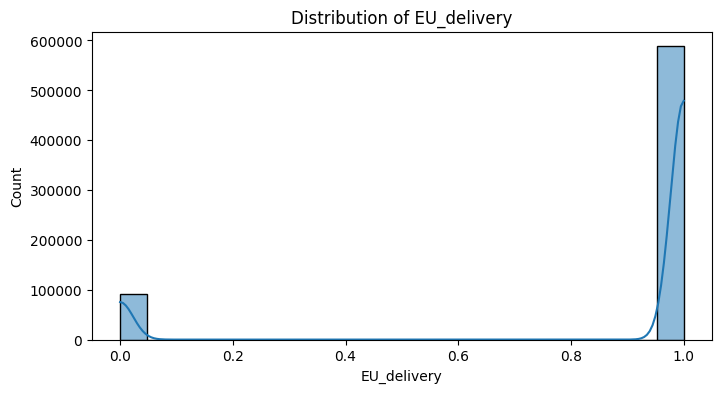

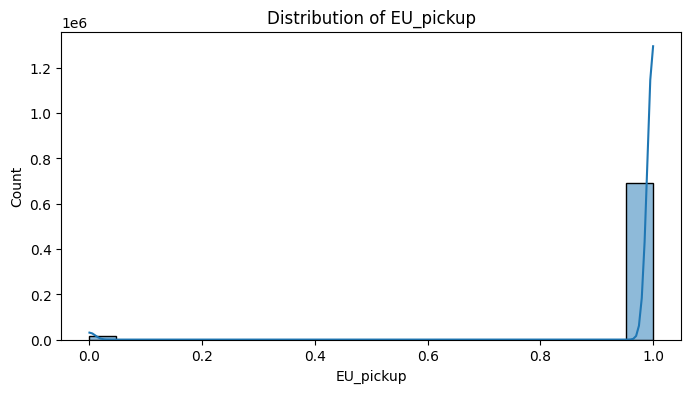

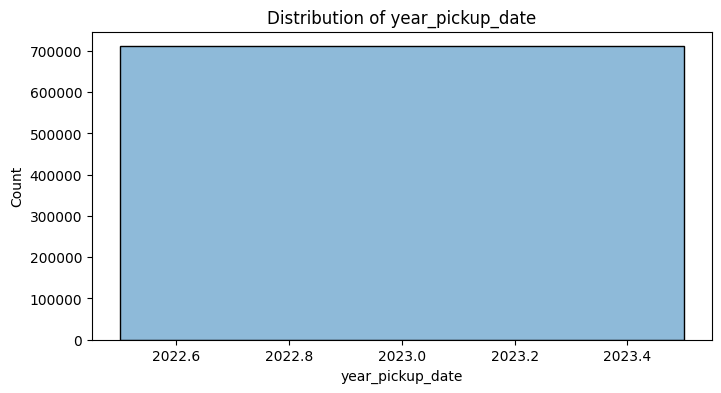

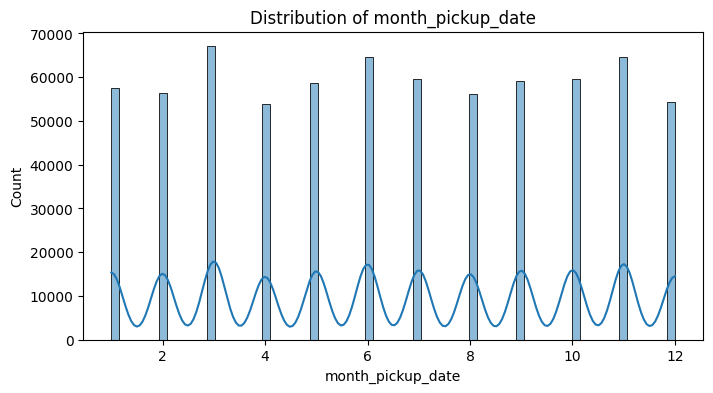

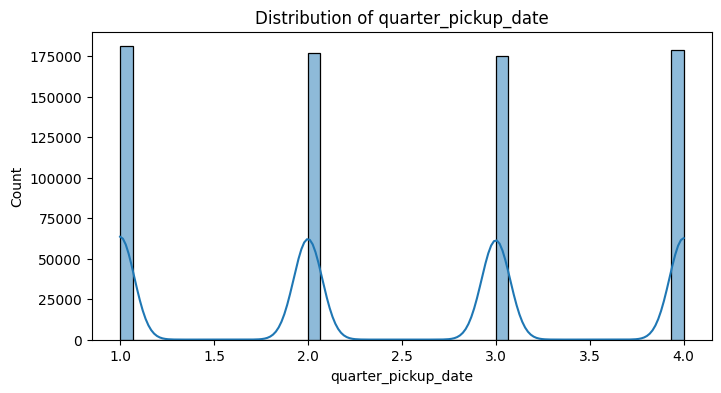

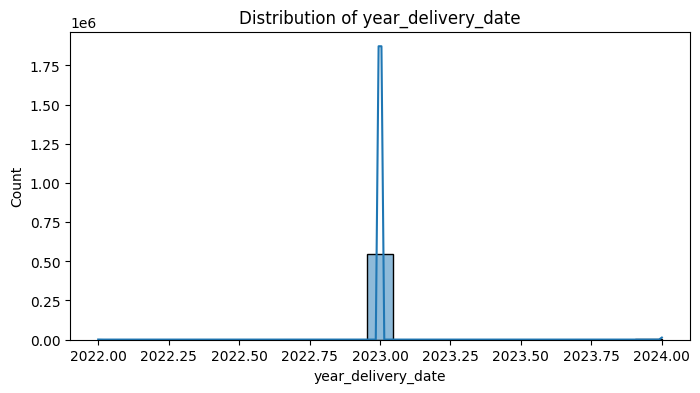

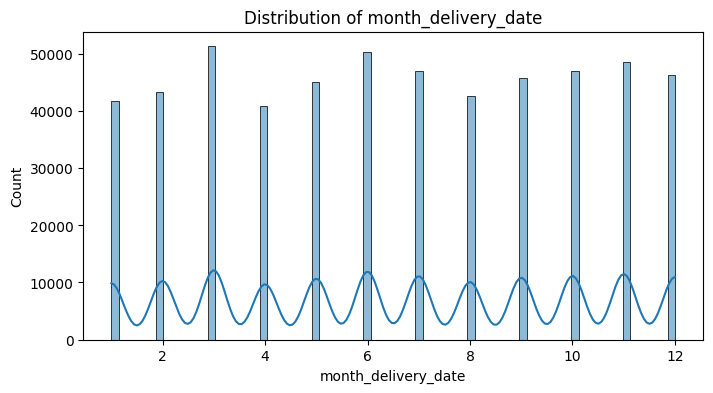

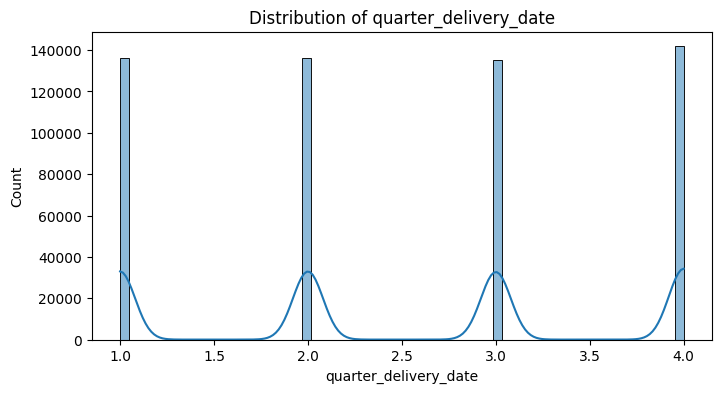

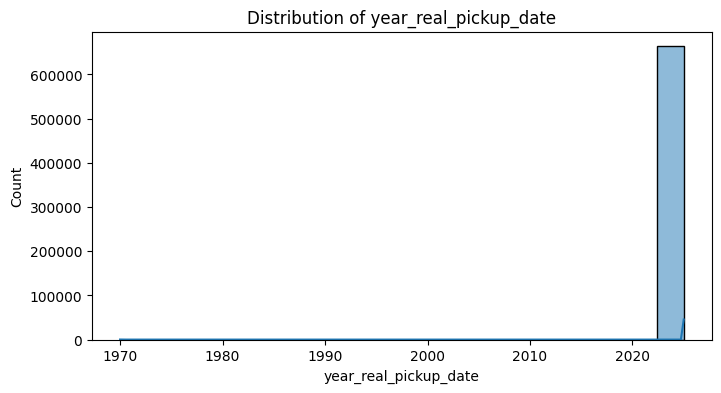

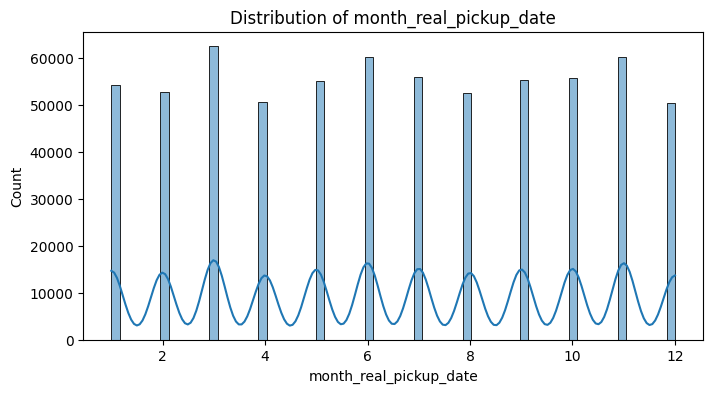

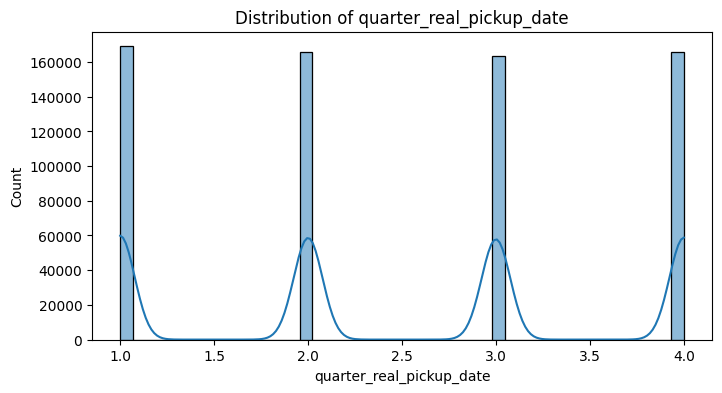

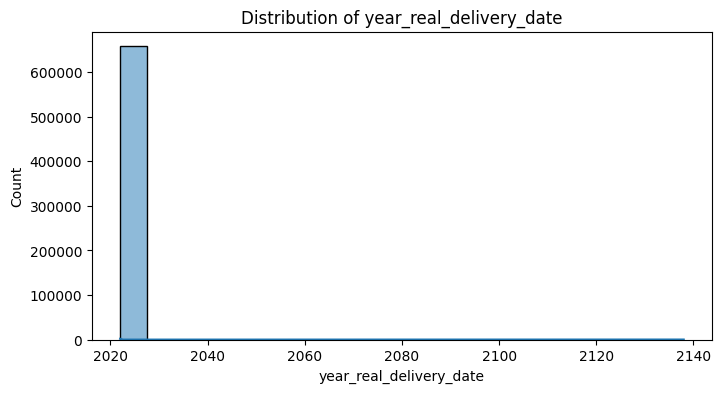

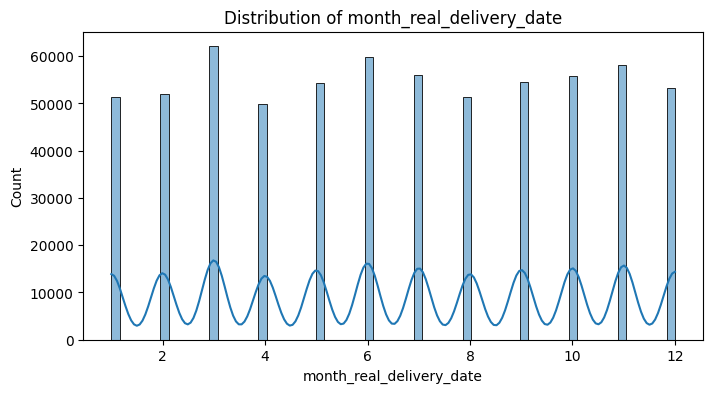

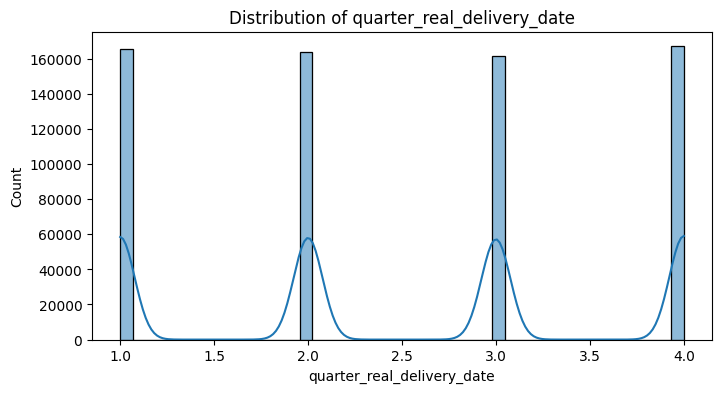

In [9]:
# Plot distribution for each numerical feature
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.show()

## Box Plots for Outlier Detection

There are some columns with many outliers.

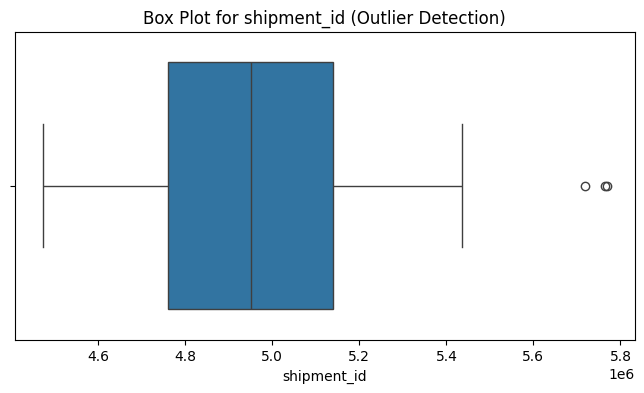

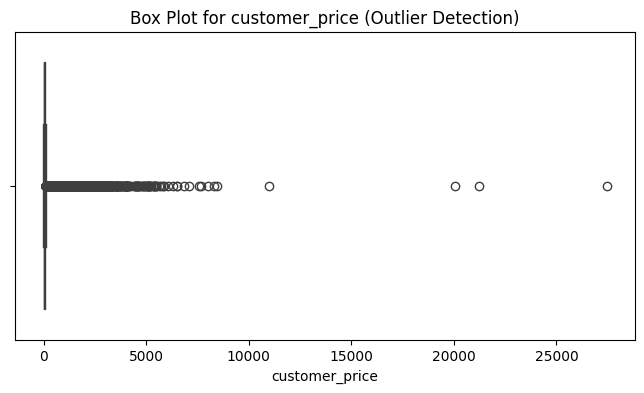

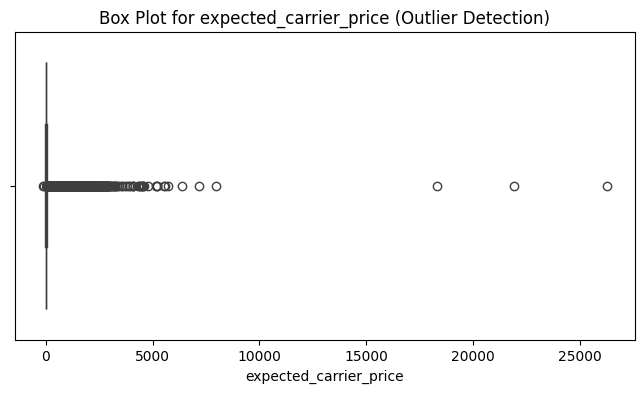

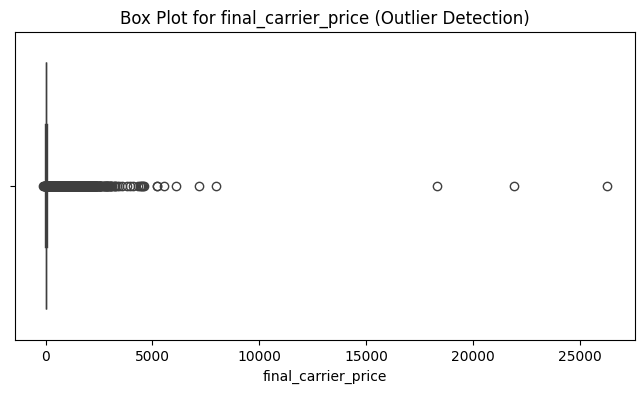

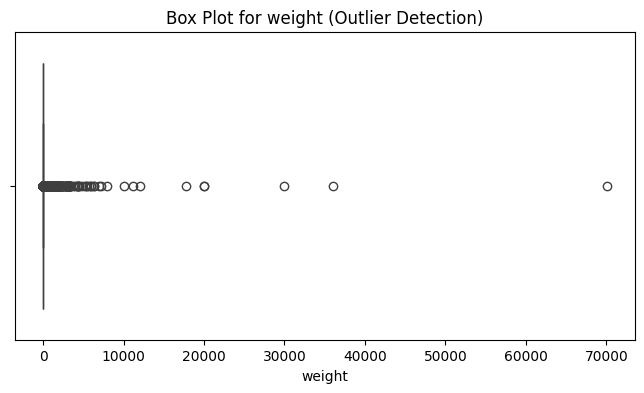

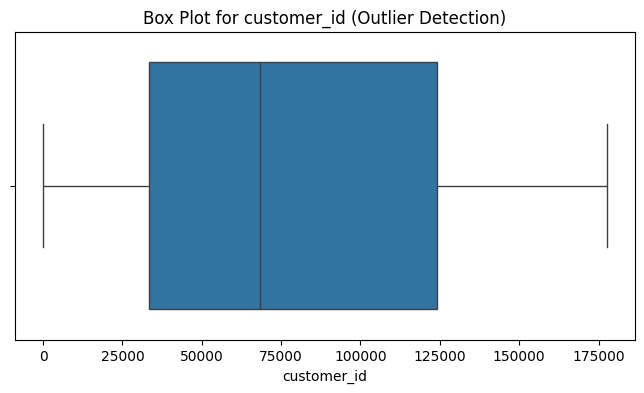

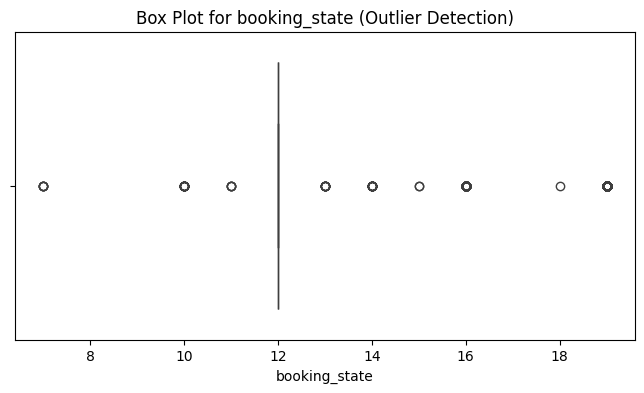

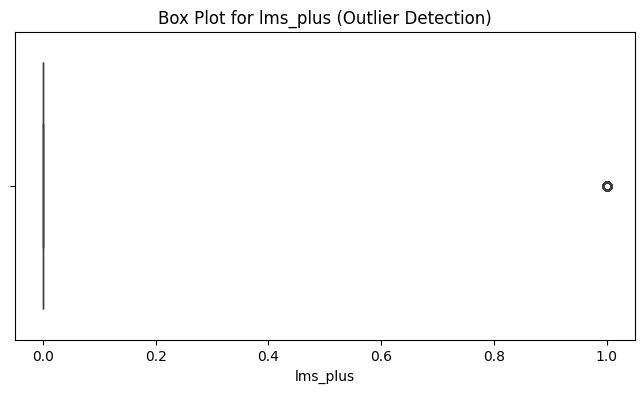

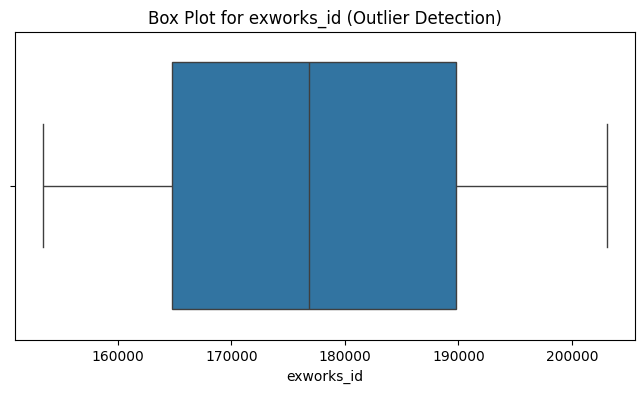

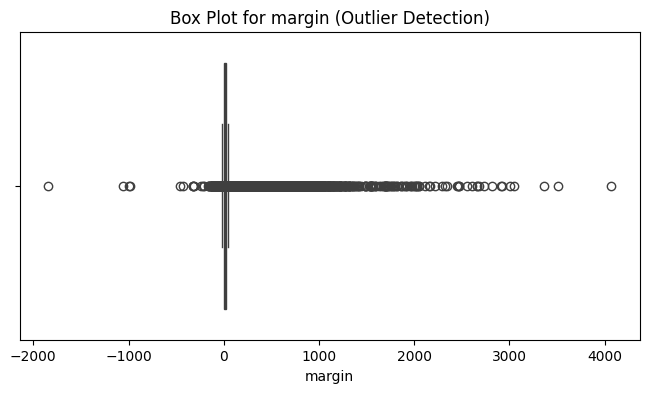

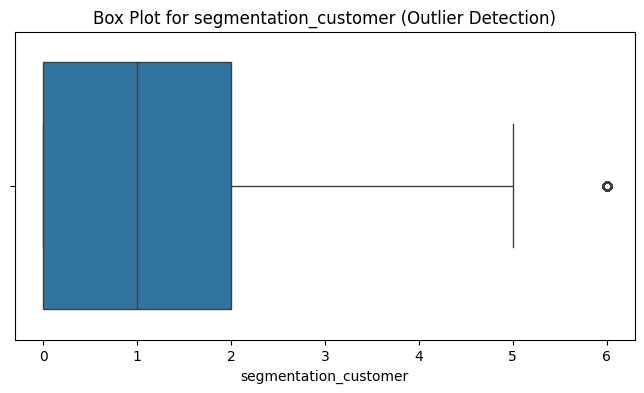

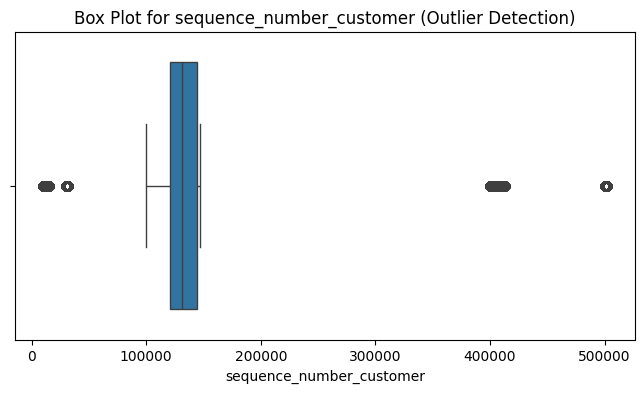

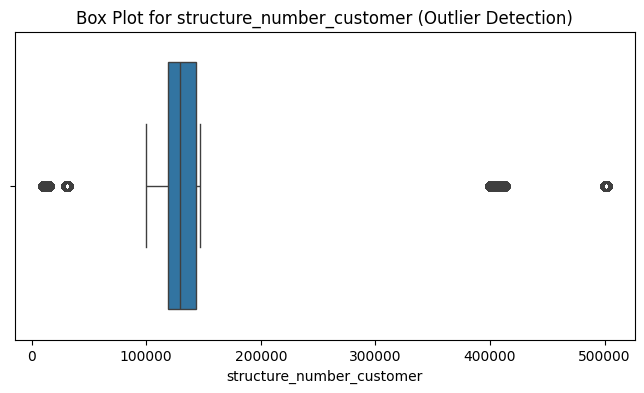

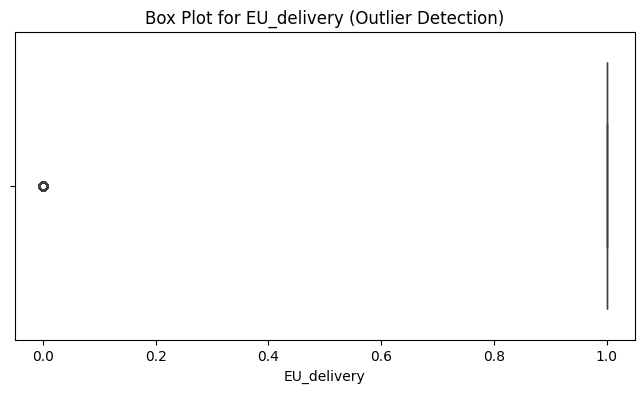

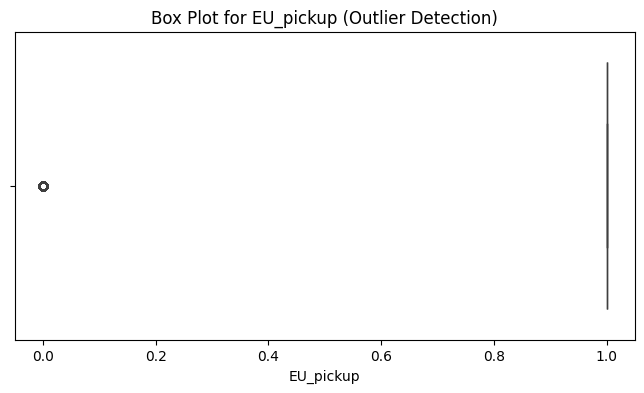

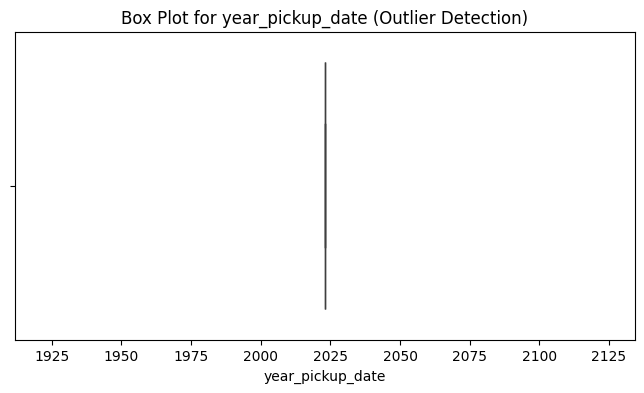

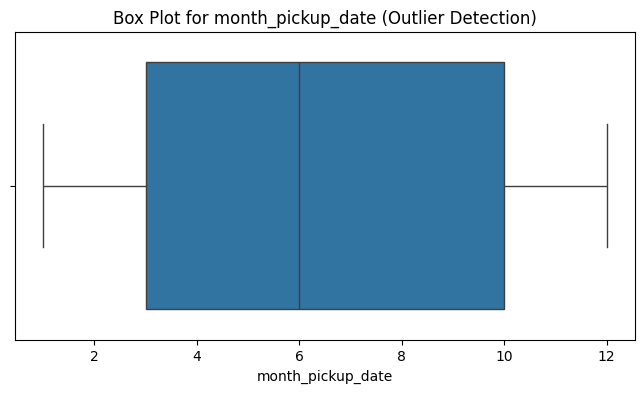

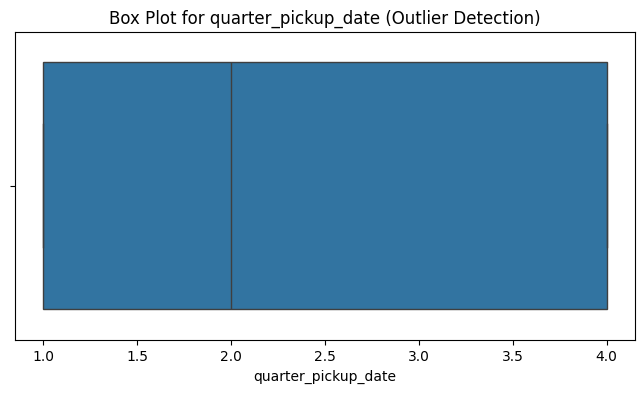

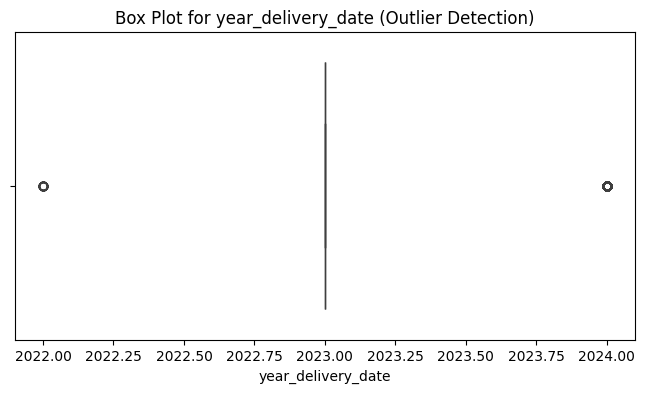

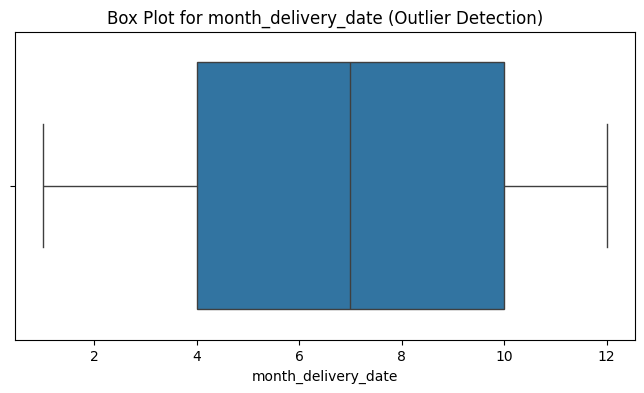

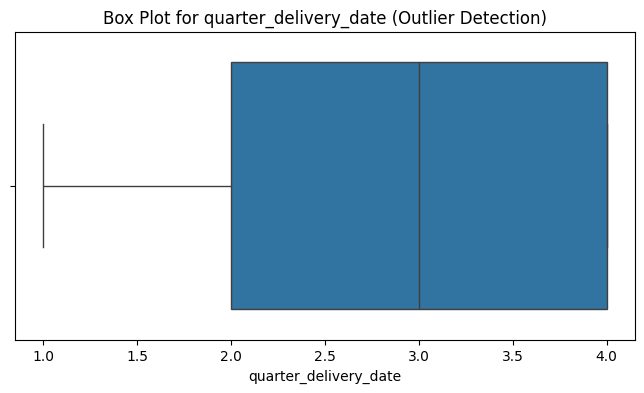

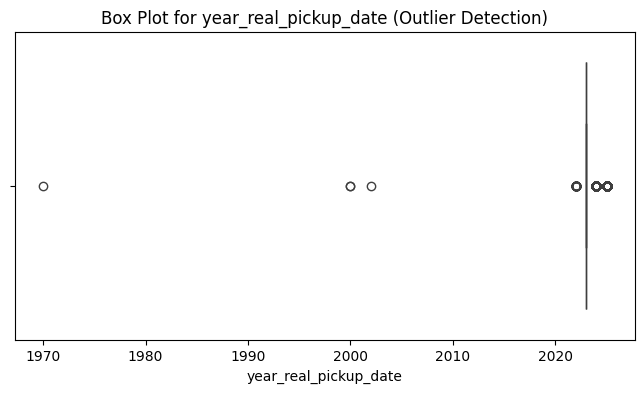

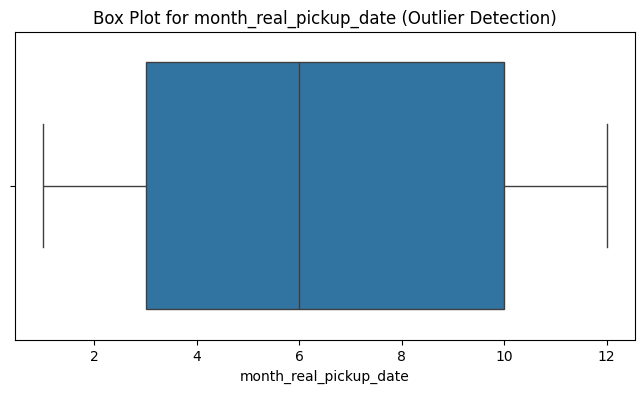

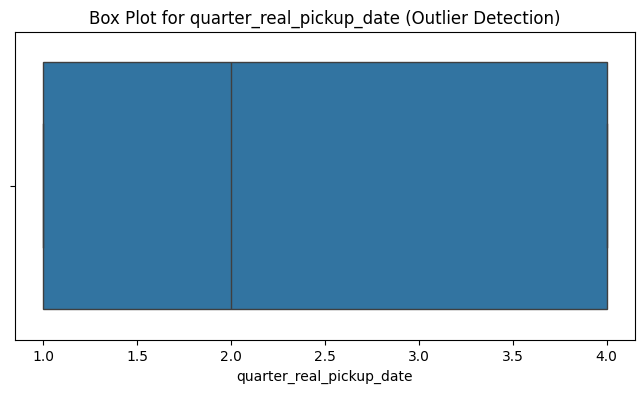

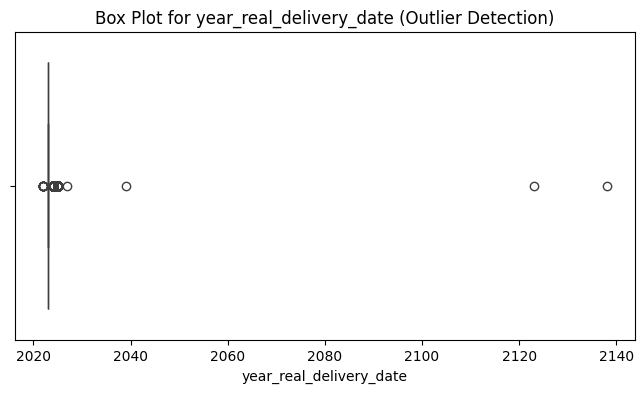

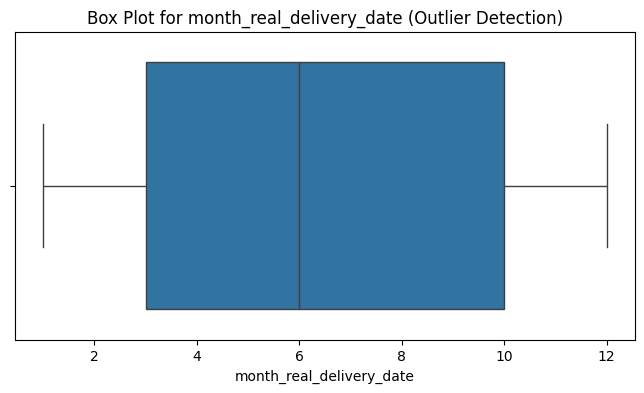

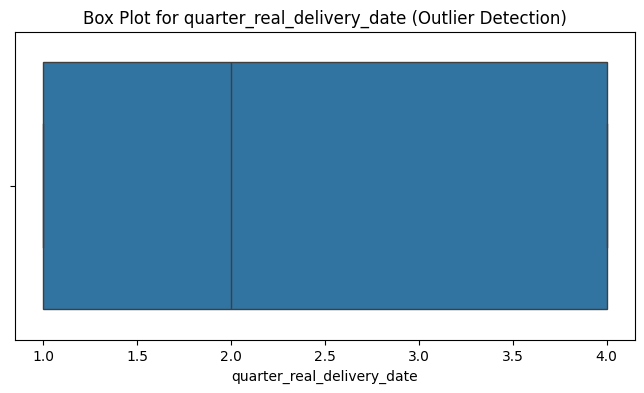

In [10]:
# Box plot for outlier detection in each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot for {feature} (Outlier Detection)")
    plt.xlabel(feature)
    plt.show()

## Feature Interaction Plots

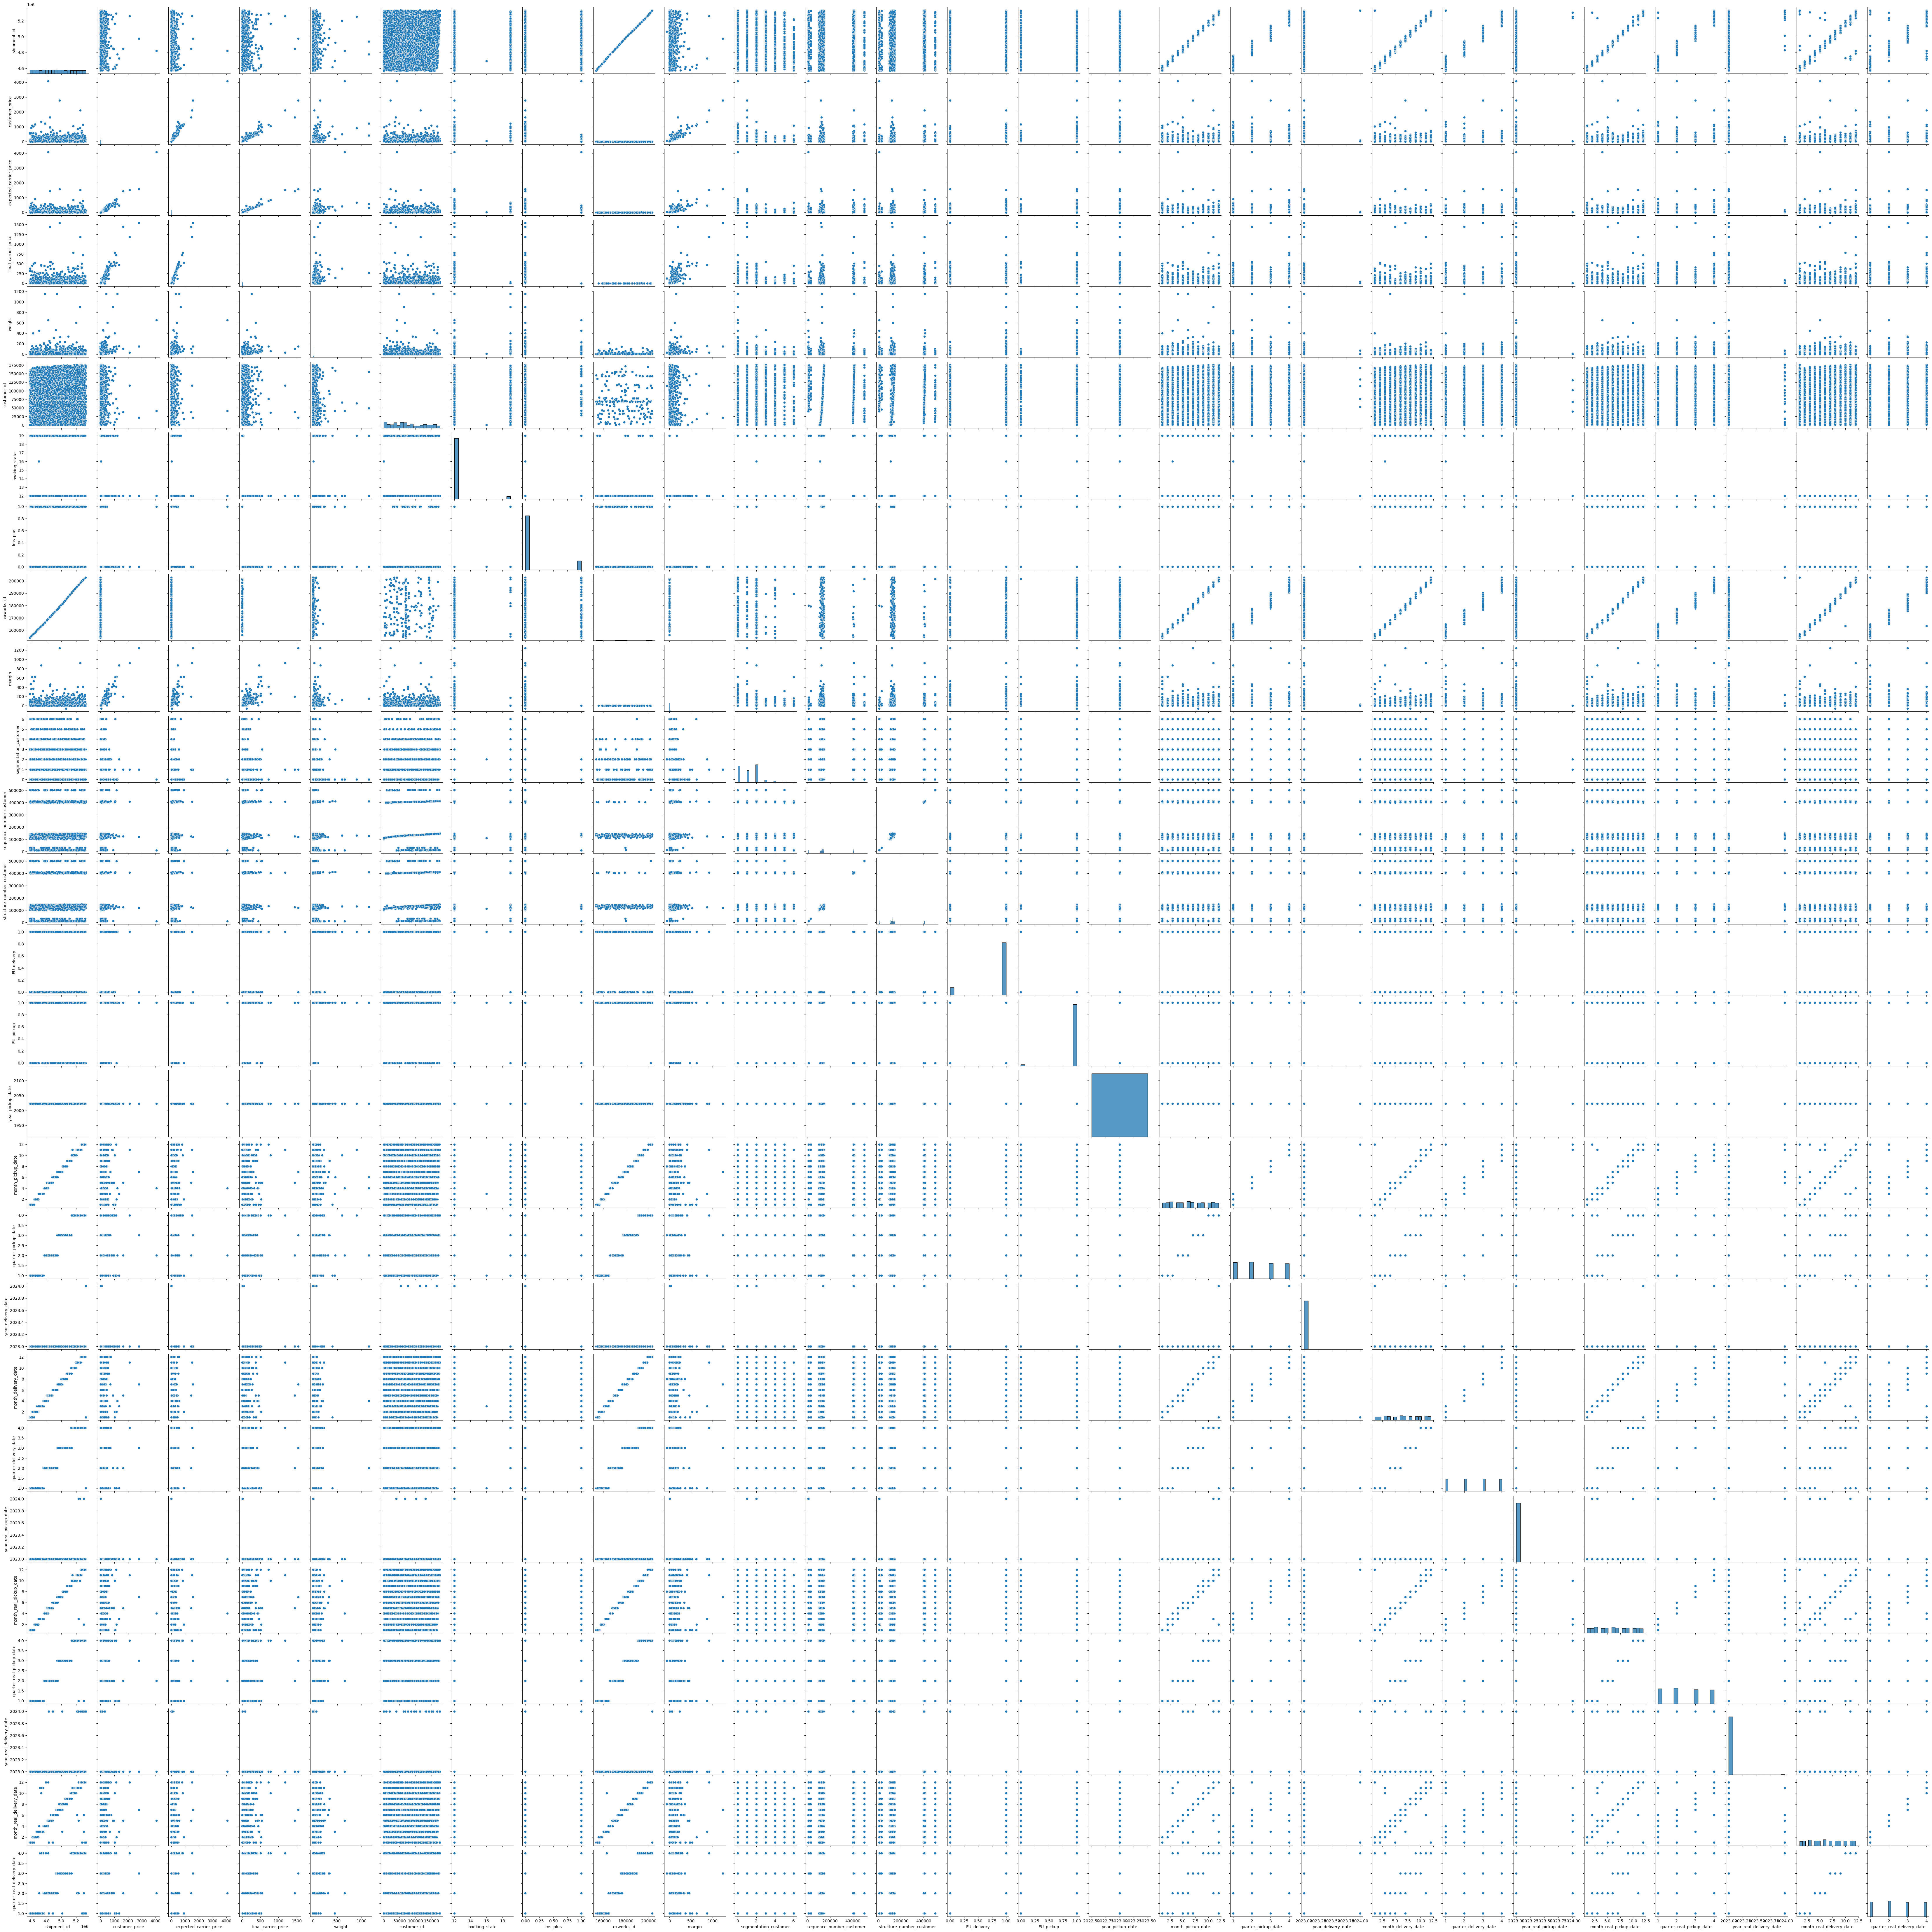

In [11]:
# Pair plot for numerical features (downsample to avoid overload if data is large)
sampled_data = df.sample(5000)  # Sample a subset to avoid overloading the plot
sns.pairplot(sampled_data[numerical_features])
plt.show()

## Target Variable Analysis

Very unbalanced for the last classes "Third_Country" and "Special".

In [12]:
df['service_type'].value_counts()

service_type
Standard         362371
Express          325761
Import            21252
Special            1298
Third_Country       334
Sameday             162
Name: count, dtype: int64

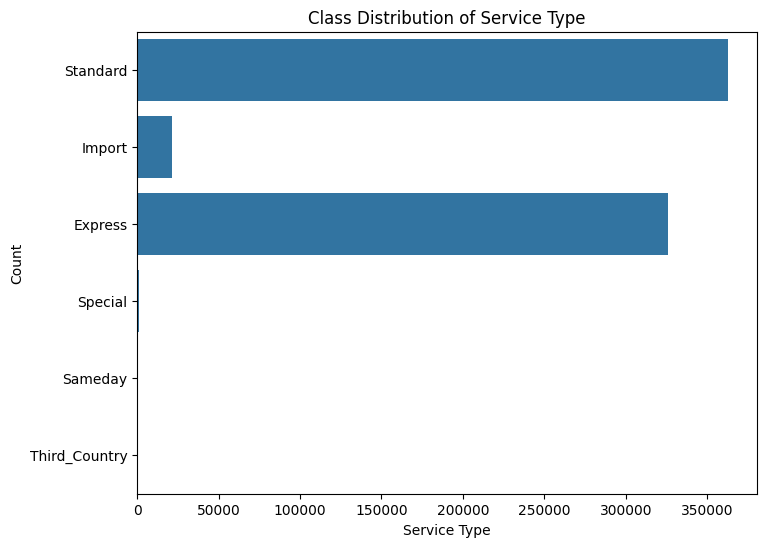

In [13]:
# Plotting the class distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(df['service_type'])
plt.title("Class Distribution of Service Type")
plt.xlabel("Service Type")
plt.ylabel("Count")
plt.show()

### Special class of the service type

We analyze in detail this class because the client told us that these cases are the ones that give the highest profit.

In [14]:
# Filter out the 'special' class cases
special_cases = df[df['service_type'] == 'Special']

In [15]:
special_cases

shipment_id  customer_price  expected_carrier_price  \
10          4557579         6850.00                 3800.00   
11776       4588795         2895.00                 1995.00   
13037       4590572          449.00                  349.00   
13247       4590976          350.00                  250.00   
15085       4593619         5650.00                 4500.00   
...             ...             ...                     ...   
708736      5328592           68.32                   52.84   
709910      5329915           68.32                   52.84   
710143      5330185         2740.00                 1890.00   
711268      5331539           77.39                   60.43   
711274      5331545           60.72                   42.66   

        final_carrier_price  weight shipment_type   insurance_type  \
10                  3800.00   807.1        Parcel  Basic_Insurance   
11776               1995.00   400.0        Parcel     No_Insurance   
13037                349.00   850.0        Parcel     No_Insurance   
13247                250.00    41.5        Parcel     No_Insurance   
15085               4500.00   920.0        Parcel     No_Insurance   
...                     ...     ...           ...              ...   
708736                50.26    56.0        Parcel     No_Insurance   
709910                50.26    52.0        Parcel     No_Insurance   
710143              1890.00  5400.0        Parcel     No_Insurance   
711268                57.88   113.0        Parcel     No_Insurance   
711274                39.77   383.0        Parcel     No_Insurance   

        customer_id domain_name  booking_state  ...  quarter_pickup_date  \
10         145995.0          DE             12  ...                  1.0   
11776       73096.0          DE             12  ...                  1.0   
13037      113273.0          DE             12  ...                  1.0   
13247       44001.0          DE             12  ...                  1.0   
15085       73096.0          DE             12  ...                  1.0   
...             ...         ...            ...  ...                  ...   
708736     160068.0          AT             12  ...                  4.0   
709910     160068.0          AT             12  ...                  4.0   
710143     142129.0          AT             12  ...                  4.0   
711268     160068.0          AT             12  ...                  4.0   
711274     160068.0          AT             12  ...                  4.0   

        year_delivery_date  month_delivery_date quarter_delivery_date  \
10                     NaN                  NaN                   NaN   
11776                  NaN                  NaN                   NaN   
13037                  NaN                  NaN                   NaN   
13247                  NaN                  NaN                   NaN   
15085                  NaN                  NaN                   NaN   
...                    ...                  ...                   ...   
708736                 NaN                  NaN                   NaN   
709910                 NaN                  NaN                   NaN   
710143                 NaN                  NaN                   NaN   
711268                 NaN                  NaN                   NaN   
711274                 NaN                  NaN                   NaN   

       year_real_pickup_date month_real_pickup_date  quarter_real_pickup_date  \
10                       NaN                    NaN                       NaN   
11776                    NaN                    NaN                       NaN   
13037                    NaN                    NaN                       NaN   
13247                    NaN                    NaN                       NaN   
15085                    NaN                    NaN                       NaN   
...                      ...                    ...                       ...   
708736                   NaN                    NaN  

Special Cases Analysis:
        shipment_id  customer_price  expected_carrier_price  \
count  1.298000e+03     1298.000000             1298.000000   
mean   5.055475e+06      336.595701              261.164599   
std    2.161241e+05     1271.832802             1175.970440   
min    4.557579e+06        0.000000                0.000000   
25%    4.866691e+06       68.610000               52.840000   
50%    5.128956e+06       89.410000               67.115000   
75%    5.246688e+06      152.557500              116.665000   
max    5.331545e+06    27450.000000            26238.000000   

       final_carrier_price        weight    customer_id  booking_state  \
count          1242.000000   1298.000000    1298.000000    1298.000000   
mean            255.189879    427.423960  146336.196456      12.214946   
std            1194.676791   1798.615644   34421.313205       1.210666   
min               0.000000      0.000000    1023.000000      11.000000   
25%              50.260000     71.0000

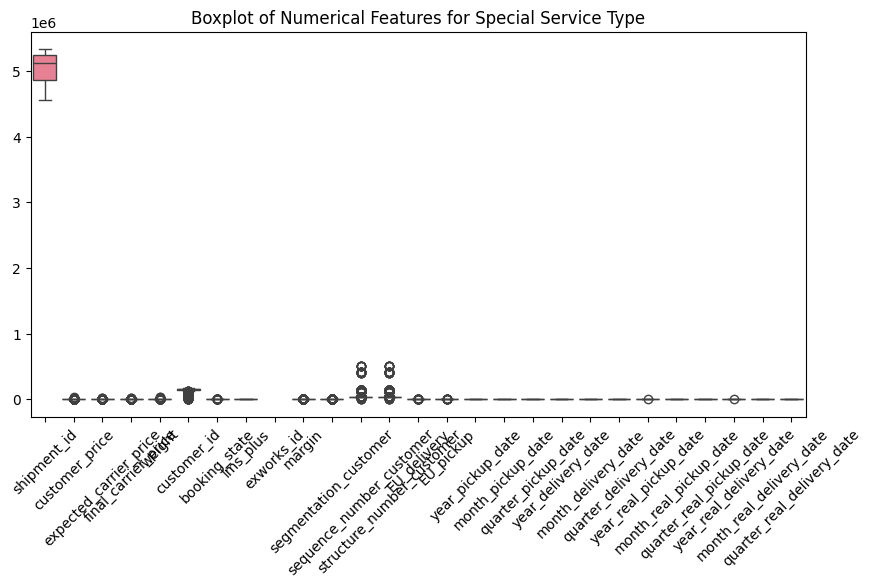

In [16]:
# Plot distribution for each numerical feature
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Display the special cases
print("Special Cases Analysis:")
print(special_cases.describe())  # General statistics for numerical features
print(special_cases.head())  # View the first few rows of the special cases

# Plot some of the key features for visual analysis
plt.figure(figsize=(10, 5))
sns.boxplot(data=special_cases[numerical_features])
plt.title('Boxplot of Numerical Features for Special Service Type')
plt.xticks(rotation=45)
plt.show()

### Margin comparison

As we can see, the margin for the "Special" class of the target variable isn't higher as we expected, but we will still consider it to be more valuable.

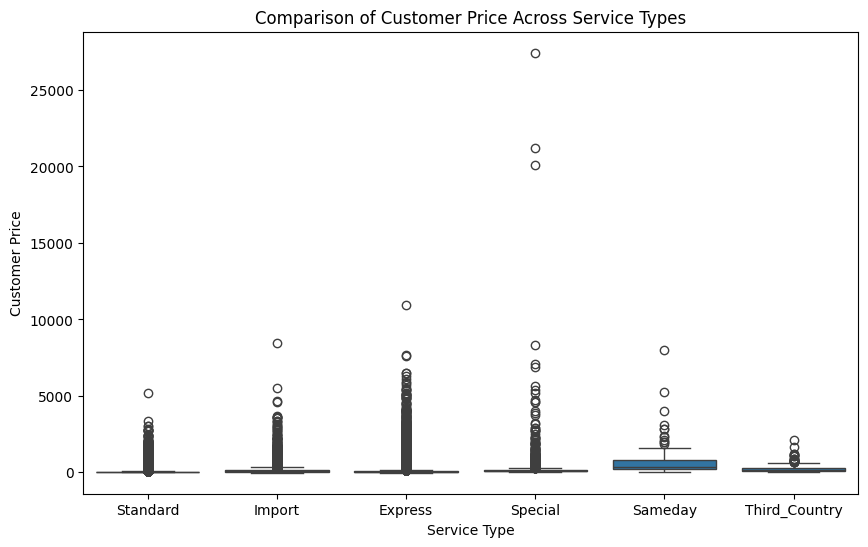

In [17]:
# Compare the customer price of 'special' cases with all other classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='service_type', y='customer_price', data=df)
plt.title('Comparison of Customer Price Across Service Types')
plt.xlabel('Service Type')
plt.ylabel('Customer Price')
plt.show()

In [18]:
# Create a new dataframe with derived margin
df_margin_analysis = df[['service_type', 'customer_price', 'final_carrier_price', 'expected_carrier_price']]

# Derive margin estimate as customer_price - final_carrier_price or expected_carrier_price if final_carrier_price is not available
df_margin_analysis['derived_margin'] = df_margin_analysis['customer_price'] - df_margin_analysis['final_carrier_price'].fillna(df_margin_analysis['expected_carrier_price'])

<ipython-input-18-427fc438419c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_margin_analysis['derived_margin'] = df_margin_analysis['customer_price'] - df_margin_analysis['final_carrier_price'].fillna(df_margin_analysis['expected_carrier_price'])


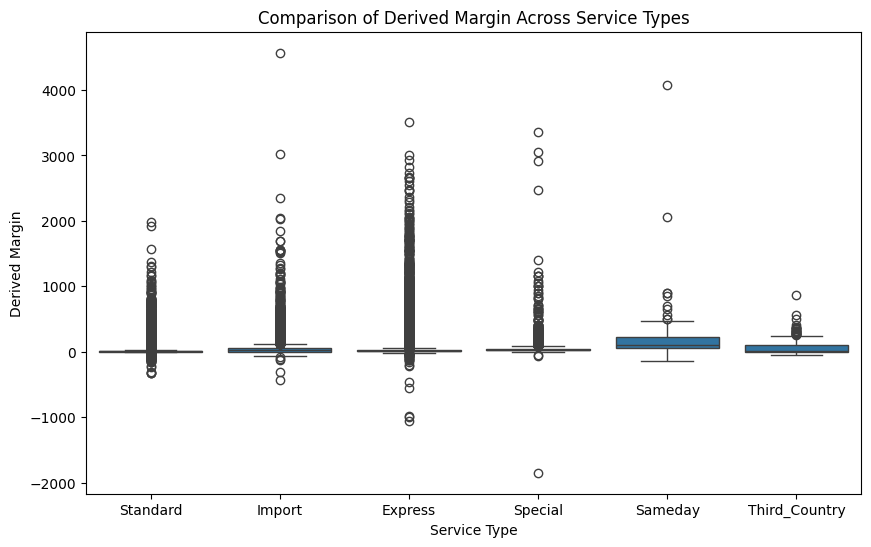

In [19]:
# Compare the derived margin of 'special' cases with all other classes
plt.figure(figsize=(10, 6))
sns.boxplot(x='service_type', y='derived_margin', data=df_margin_analysis)
plt.title('Comparison of Derived Margin Across Service Types')
plt.xlabel('Service Type')
plt.ylabel('Derived Margin')
plt.show()

## Feature Importance Analysis (initial)

Analyze the feature importance before the preprocessing.

It uses a smaller sample to speed up the analysis in this phase.

The feature importance will also be used later to have a better view after the preprocessing.

*Note*: For the categorical variables, we apply the One-Hot Encoding for the columns with less than 10 classes, while we apply "Label Encoding" for the ones with a higher count.

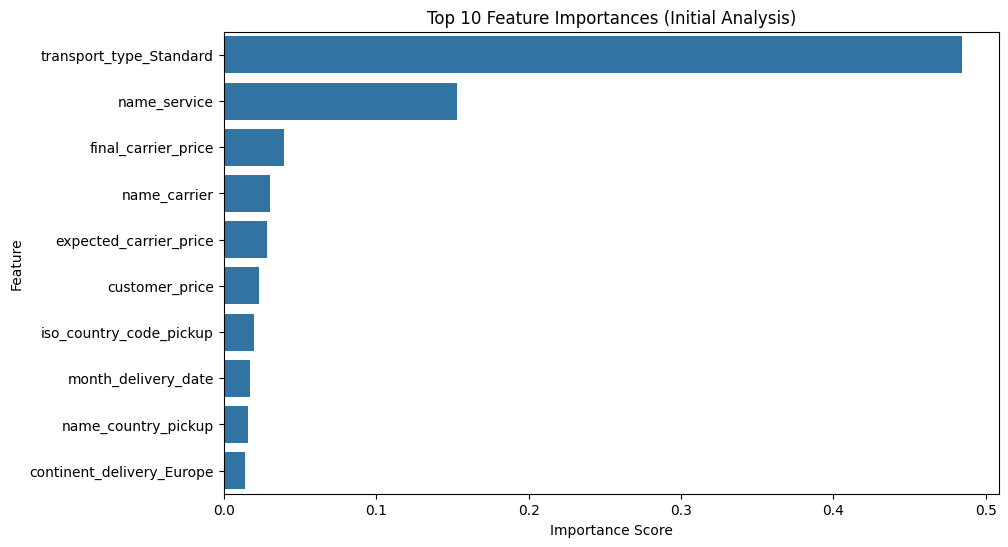

In [5]:
# Downsample the data to avoid memory overload
df_sampled = df.sample(frac=0.1, random_state=42)  # Use only 10% of the data

# Separate the target column before any transformations
target_column = 'service_type'
y = df_sampled[target_column]

# Drop the target column from the feature set
X = df_sampled.drop(columns=[target_column])

# Split numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Handle categorical columns
for col in categorical_cols:
    if X[col].nunique() > 10:  # High cardinality threshold (e.g., > 10 unique values)
        # Apply Label Encoding for high-cardinality features
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        # Apply One-Hot Encoding for low-cardinality features
        X = pd.get_dummies(X, columns=[col], drop_first=True)

# Encode categorical target column if not already encoded
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)

# Train a RandomForestClassifier for feature importance analysis
rf = RandomForestClassifier(n_estimators=20, random_state=42)  # Reduced number of estimators to limit memory usage
rf.fit(X, y)

# Plot feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 10 Feature Importances (Initial Analysis)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Correlation with Target Variable

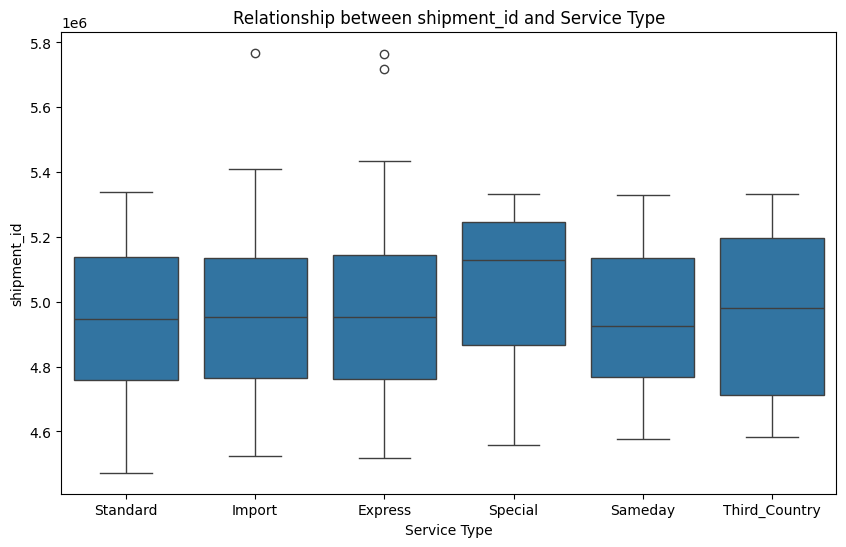

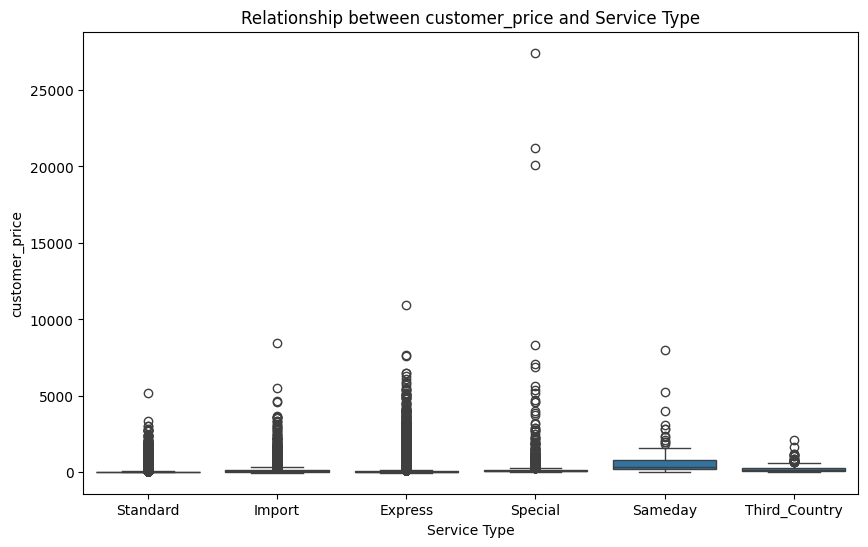

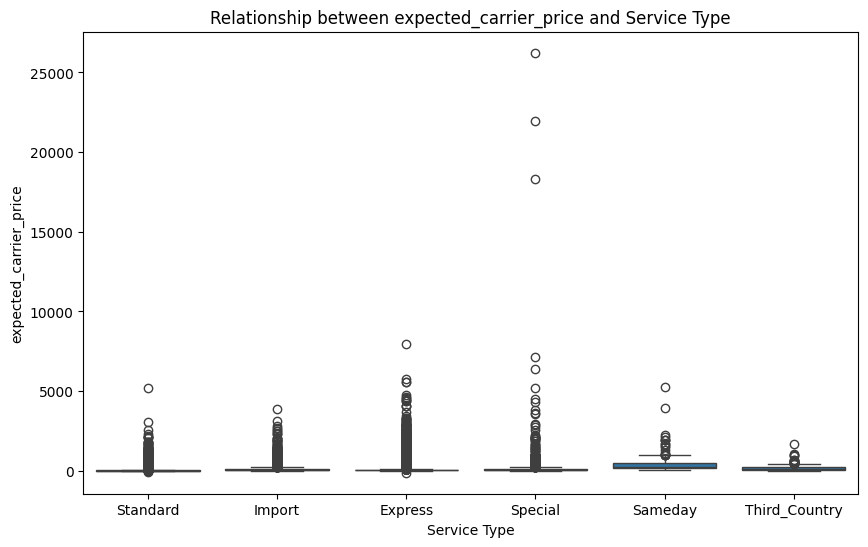

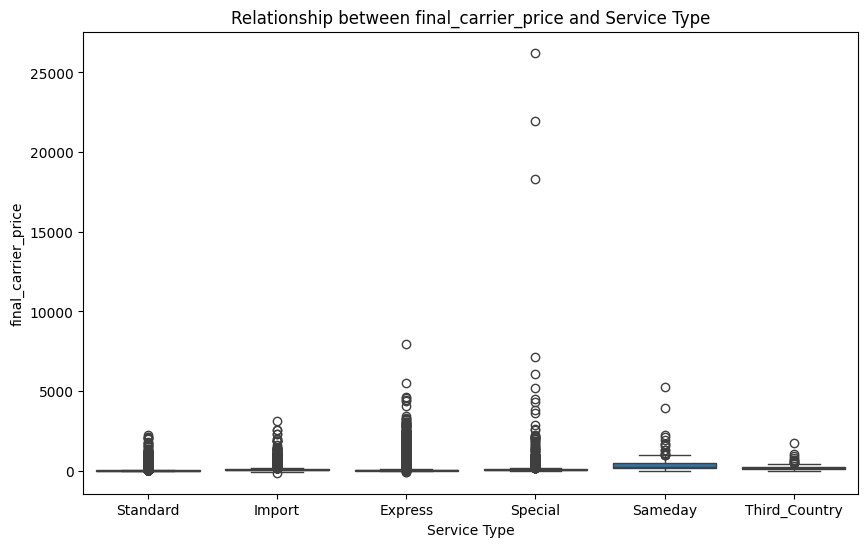

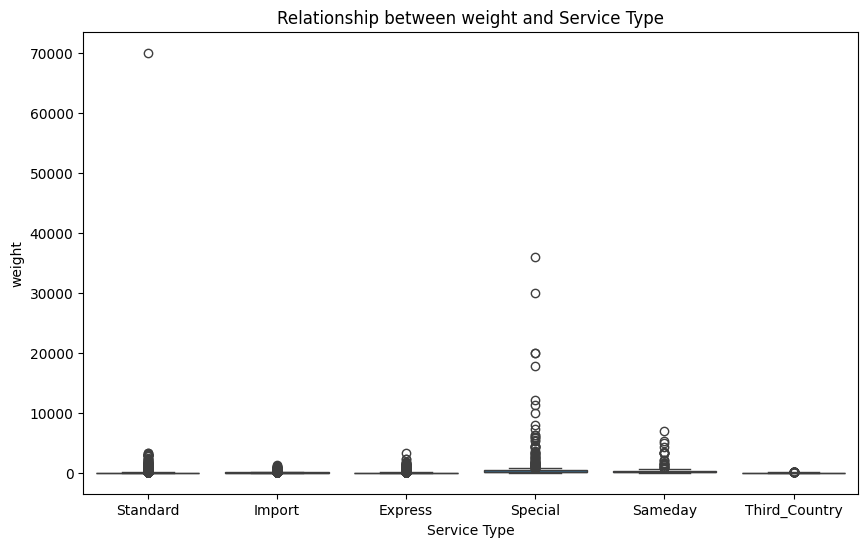

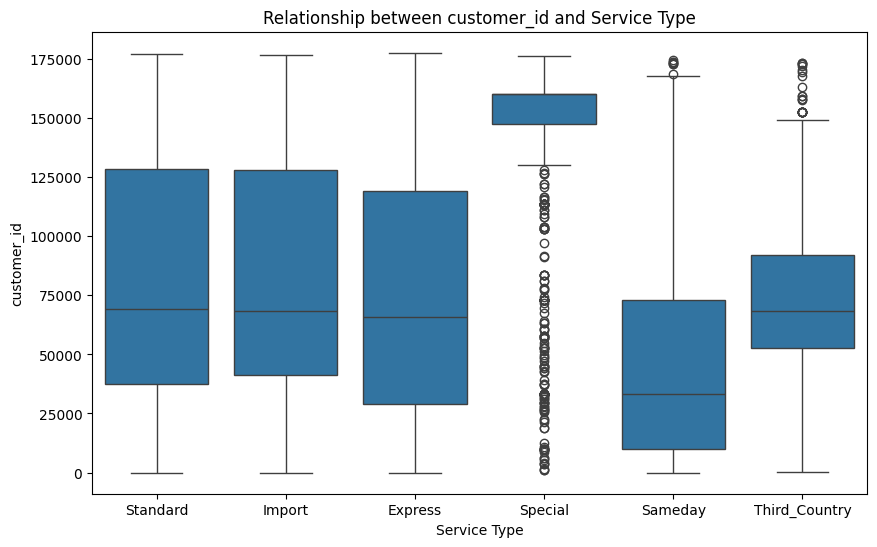

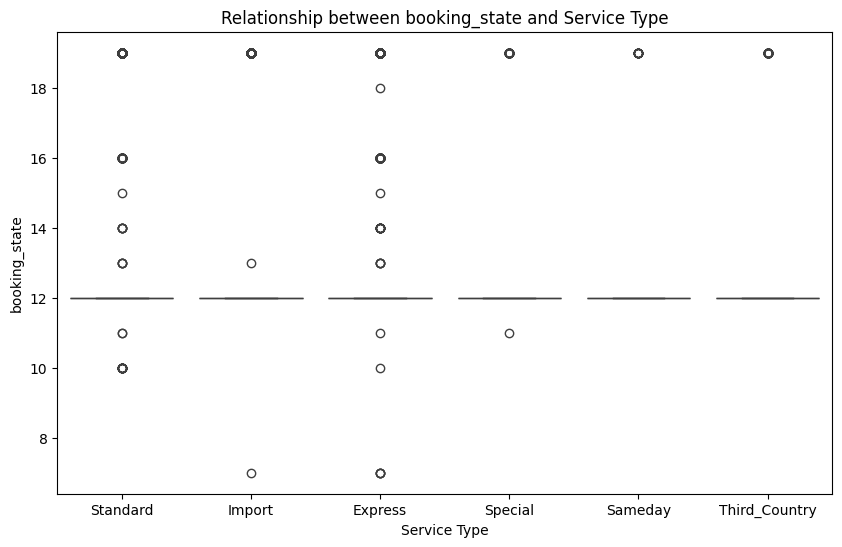

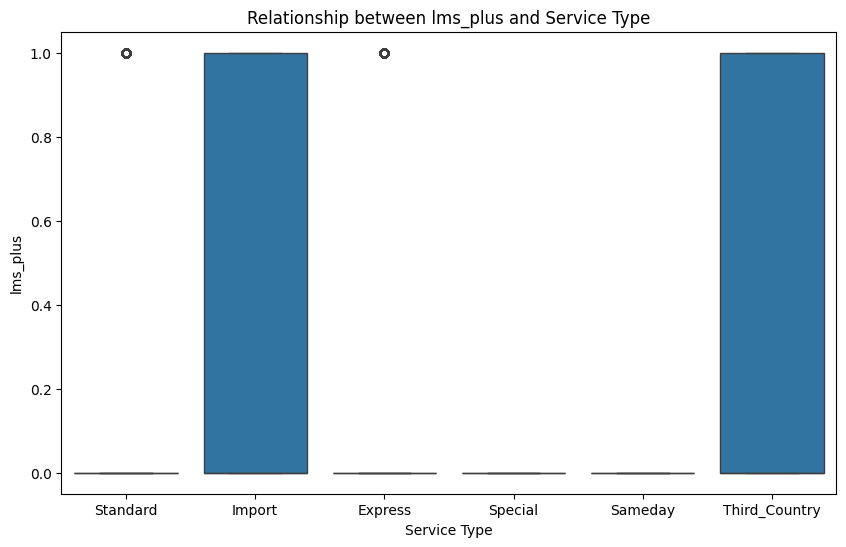

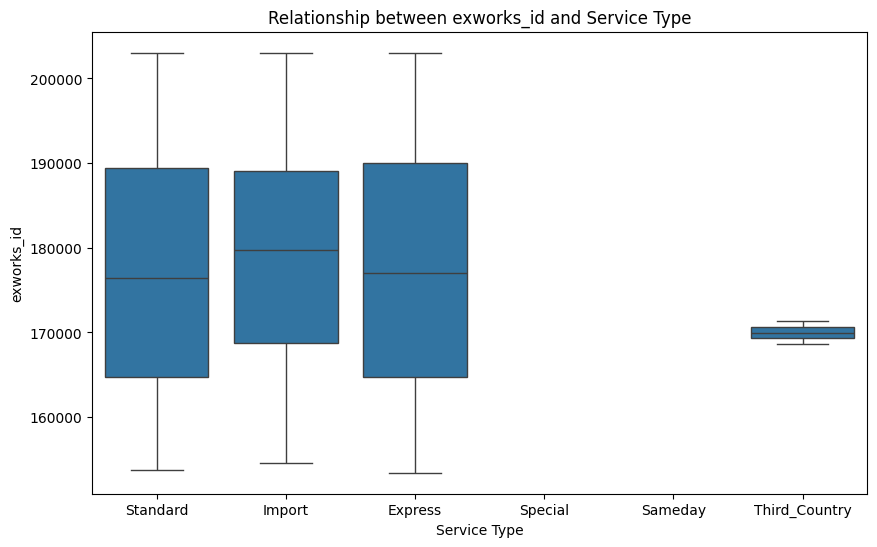

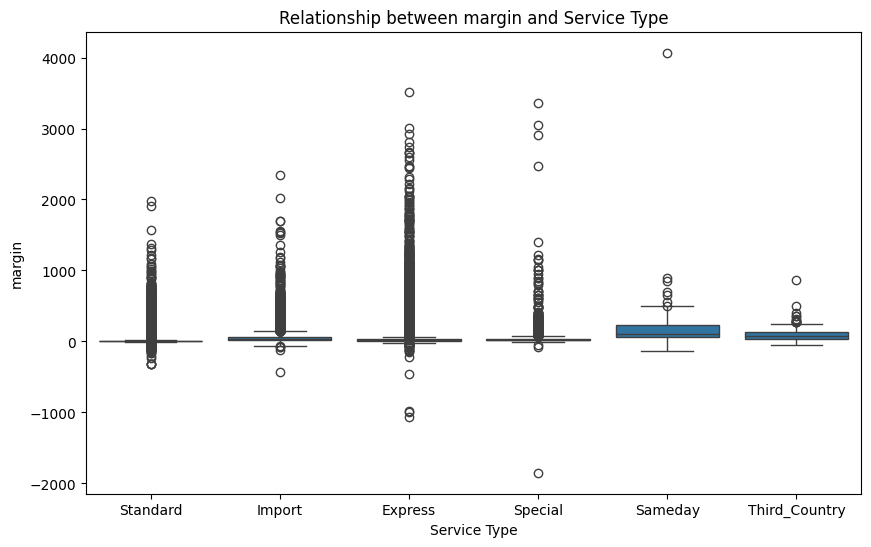

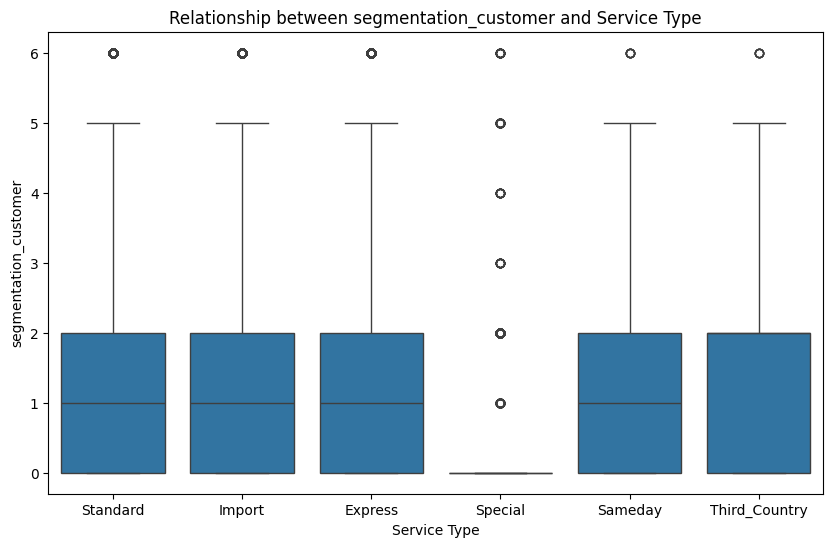

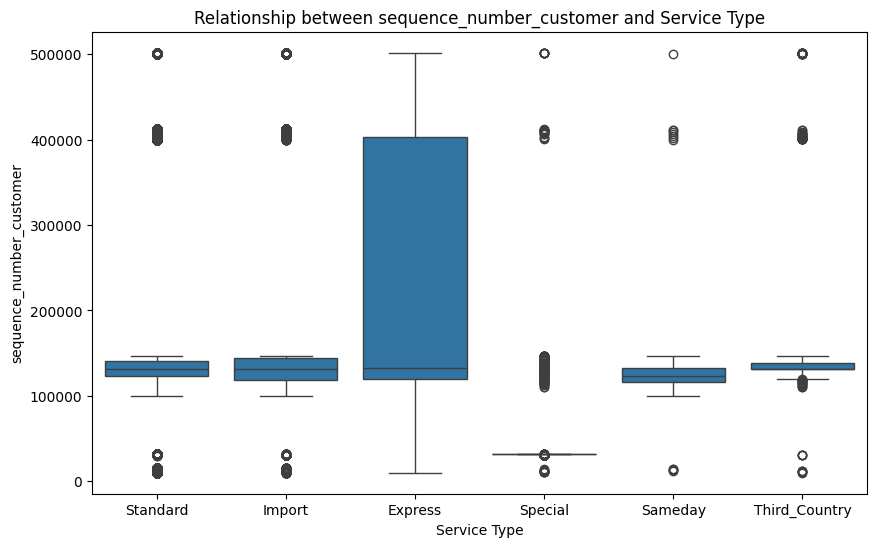

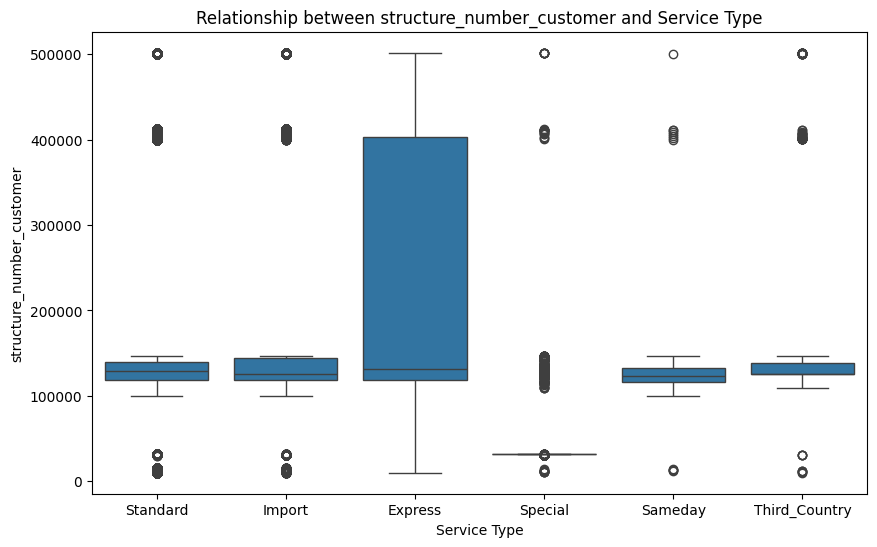

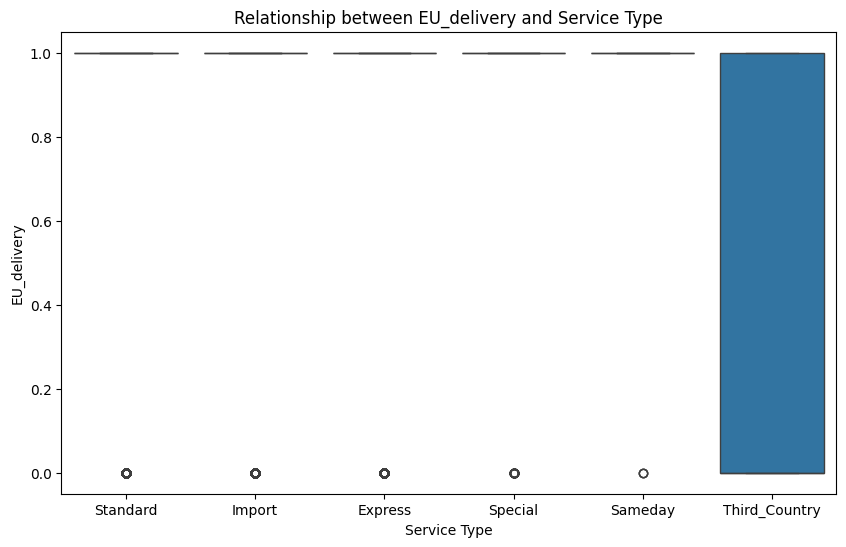

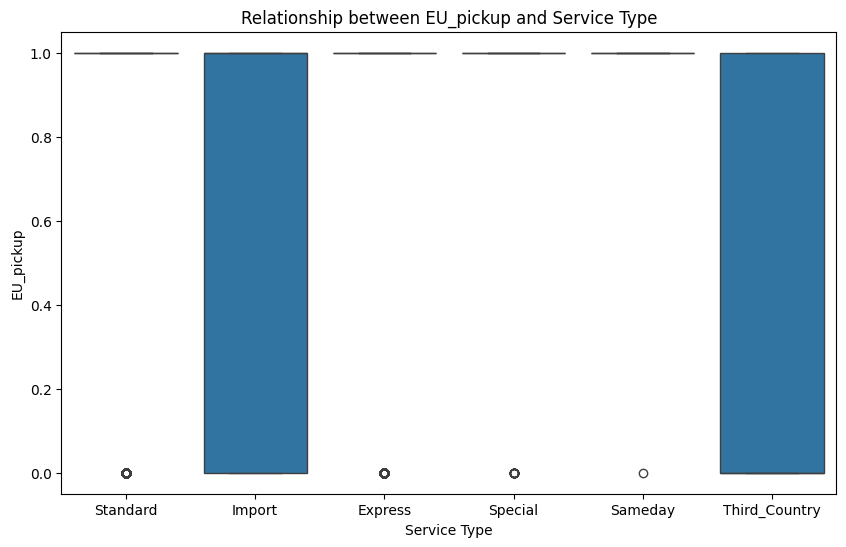

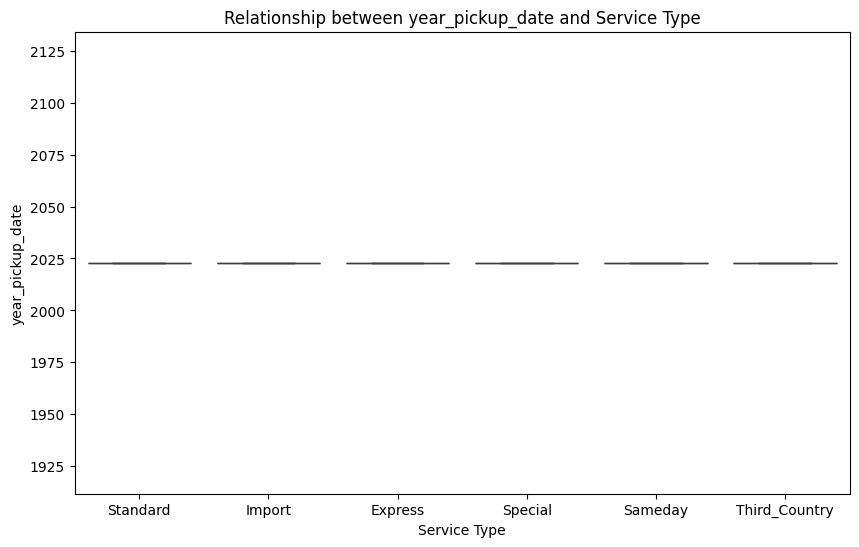

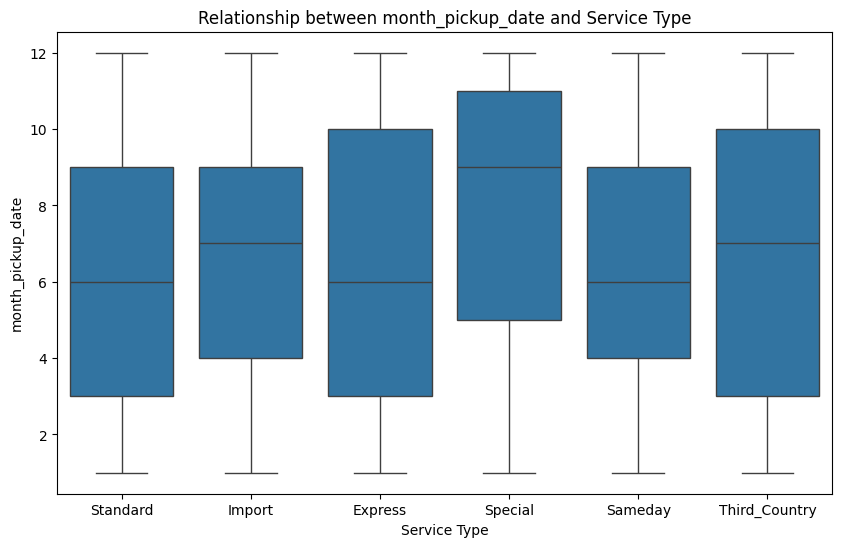

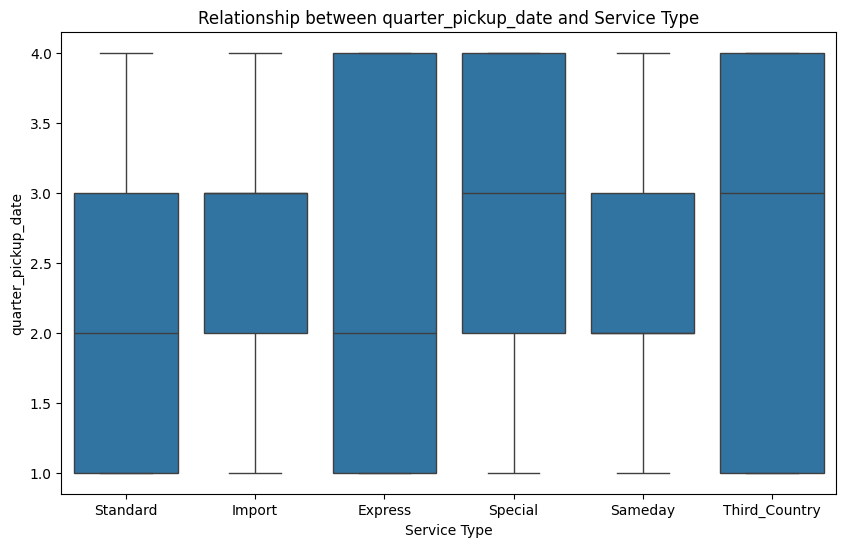

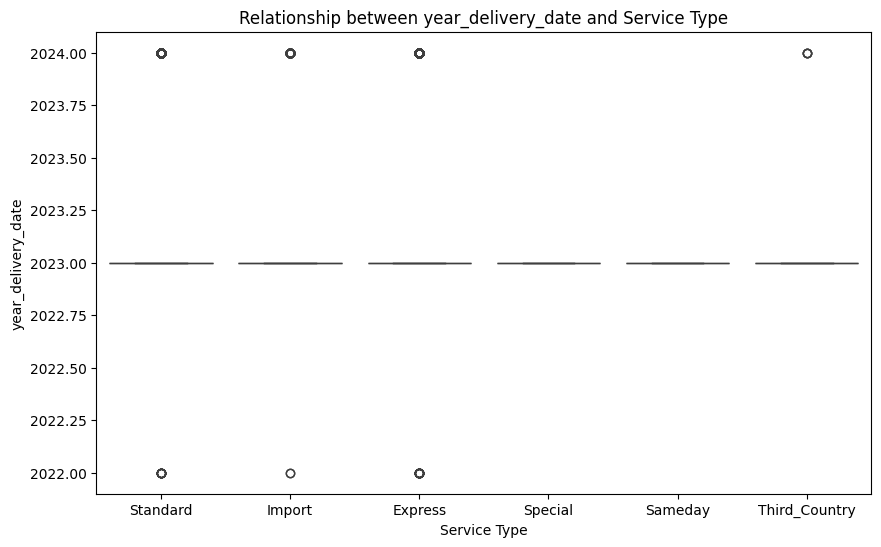

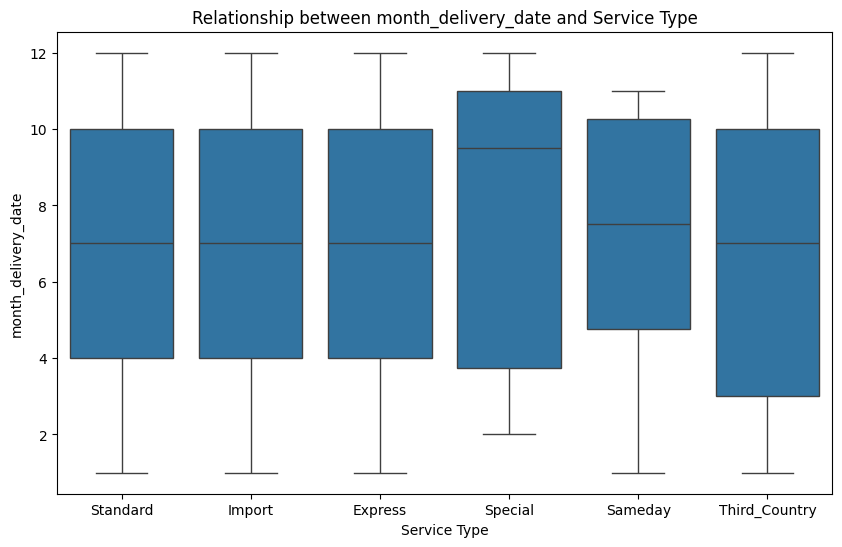

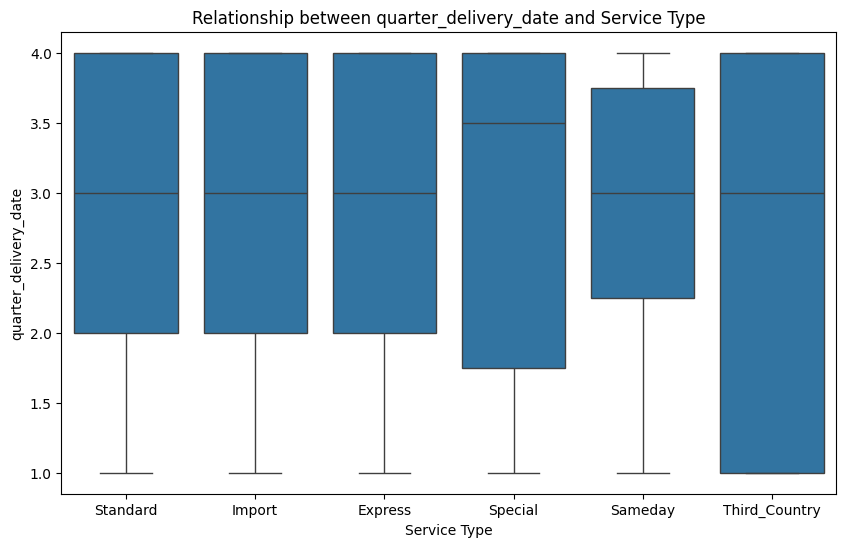

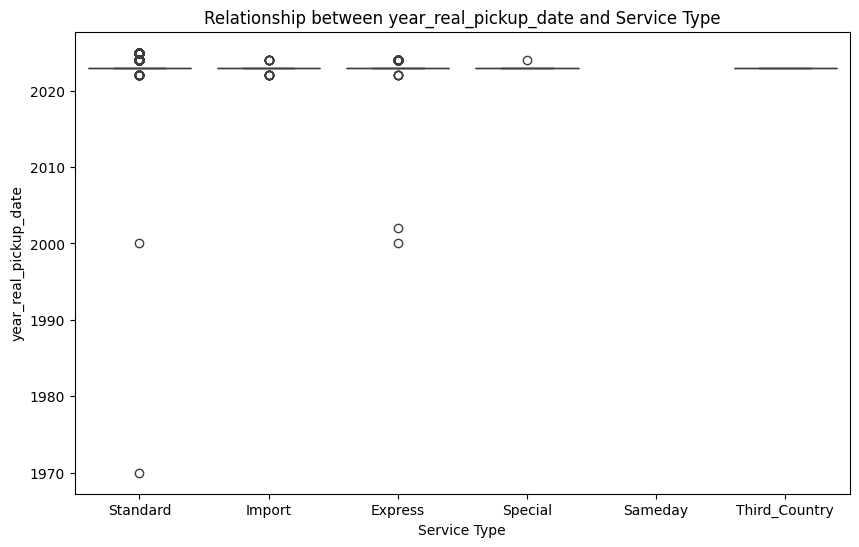

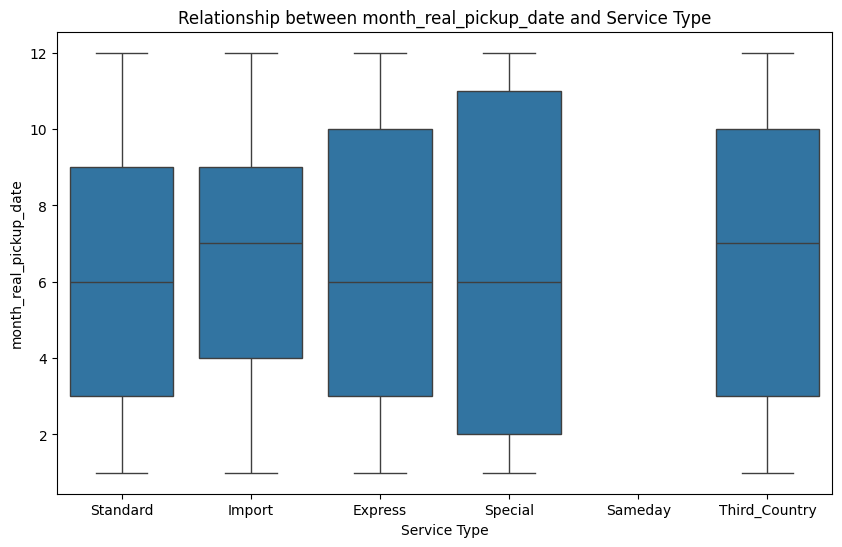

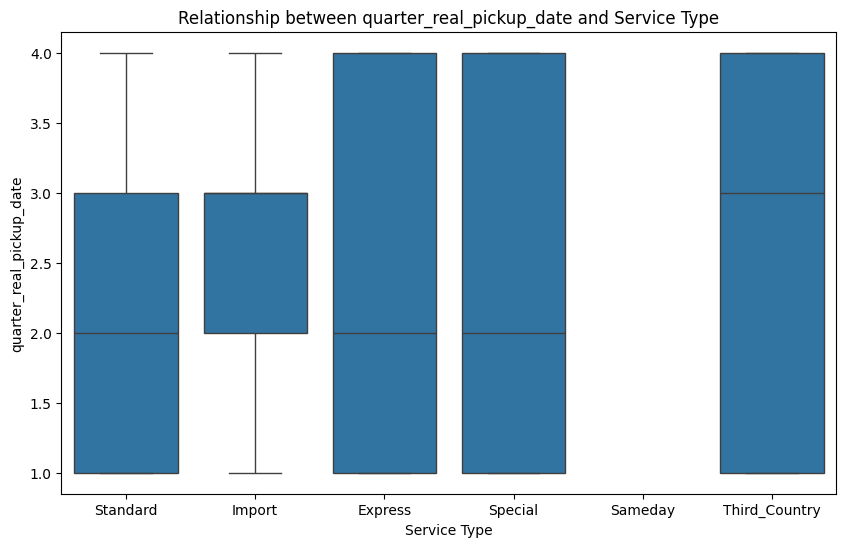

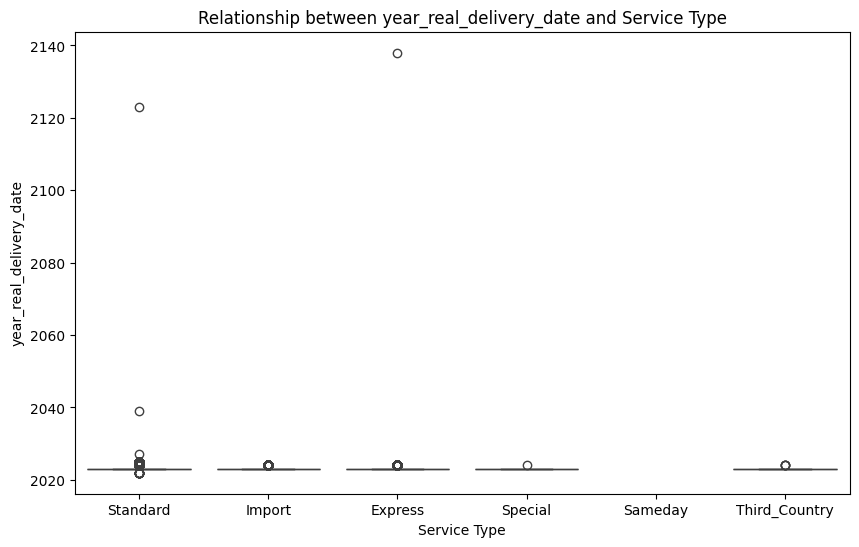

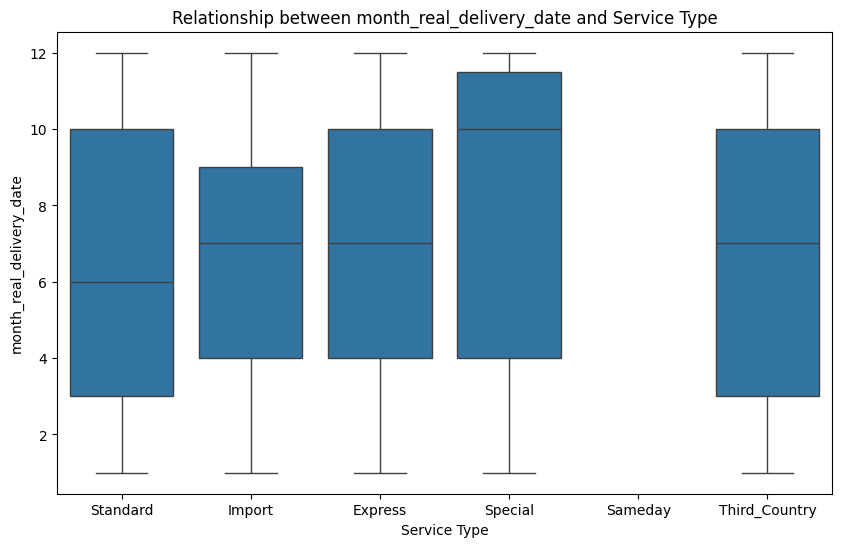

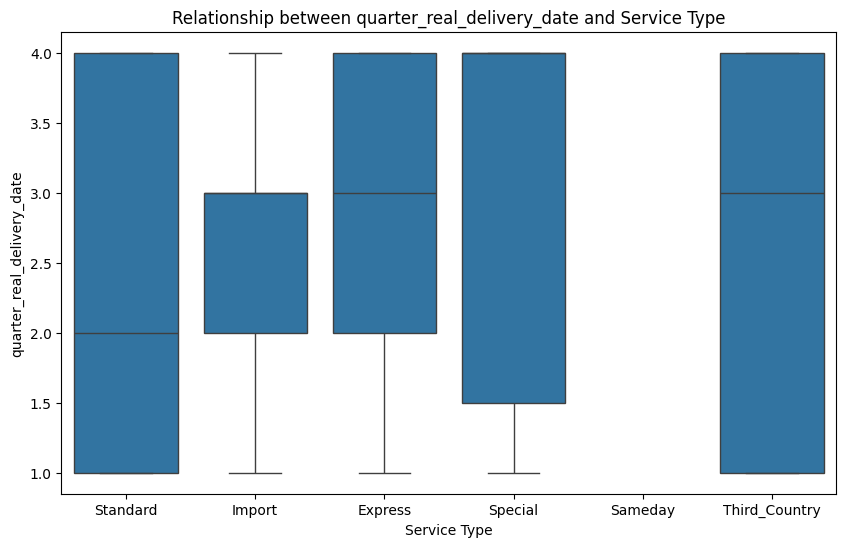

In [21]:
# Box plots to see how numerical features relate to the target variable
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['service_type'], y=df[feature])
    plt.title(f"Relationship between {feature} and Service Type")
    plt.xlabel("Service Type")
    plt.ylabel(feature)
    plt.show()

# Preprocessing

In this phase, we treat everything we identified in the previous step.

## Removing unavailable columns at the moment of the prediction

These are the columns that aren't avaiable when making the prediction, so they represent something akin to "Target Leakage".

In [3]:
columns_to_exclude = [
    'year_delivery_date', 'month_delivery_date',
    'quarter_delivery_date', 'year_real_delivery_date',
    'month_real_delivery_date', 'quarter_real_delivery_date',
    'final_carrier_price',
    'margin',
    'year_pickup_date', 'month_pickup_date', 'quarter_pickup_date',
    'year_real_pickup_date', 'month_real_pickup_date', 'quarter_real_pickup_date',
    'domain_name_service',
    'domain_name_customer',
    'transport_type', 'shipment_id',
    'name_service'
]

In [4]:
# Drop the identified columns to prevent label leakage
df = df.drop(columns=columns_to_exclude, axis=1)

## Handling missing values

To handle the missing values, we approached this problem in the following way:
- For the **service_type**, the rows that are missing the label, we just remove them.
- For the **numerical features**, we replaced them with the median, given the high number of outliers.
- For the **categorical features**, we replaced them with the value *missing*, which we intentionally wanted to introduce as a "new value" to represent the fact that the feature is missing.

In [5]:
# columns with NAs (with more than 0)
df.isna().sum()[df.isna().sum() > 0]

weight                              280
shipment_type                       280
insurance_type                      280
customer_id                         280
domain_name                         280
lms_plus                            280
exworks_id                       683441
main_industry_name_customer      222510
industry_sector_name_customer    222510
segmentation_customer            116856
sequence_number_customer            280
structure_number_customer           280
is_master_customer                  280
domain_name_delivery                280
postal_code_delivery              16080
city_delivery                       281
name_country_delivery             30872
iso_country_code_delivery         30894
continent_delivery                30872
EU_delivery                       30872
domain_name_pickup                  280
postal_code_pickup                 1569
city_pickup                         281
name_country_pickup                2328
iso_country_code_pickup            2328


In [6]:
# Drop columns with too many missing values (more than 70% missing)
threshold = len(df) * 0.7
df = df.dropna(axis=1, thresh=threshold)

# Remove rows where 'service_type' is NA
df = df.dropna(subset=['service_type'])

# Fill numeric columns with median and categorical columns with 'missing'
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna('missing')

/tmp/ipykernel_267168/1245711723.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].fillna('missing')


## Feature Encoding

As mentioned before, we use the **One-Hot Encoding** for features with less than 10 classes, while we use the **Label Encoding** for the others that have a higher count.

In [7]:
# Split Features and Target
X = df.drop(["service_type"], axis=1)
y = df["service_type"]

In [8]:
# Encoding Strategy for Features
# Split categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Apply Encoding to Categorical Features
# Label Encoding for high-cardinality features, One-Hot Encoding for low-cardinality features
for col in categorical_cols:
    if X[col].nunique() > 10:  # High cardinality threshold (e.g., >10 unique values)
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        X = pd.get_dummies(X, columns=[col], drop_first=True)

## Train Test Split, SMOTE, and Scaling

Here we perform the *train_test_split* in a custom way.

In fact, in this phase, we:
1. Split the dataset in train and test (using 80% / 20% division), considering the **stratify** parameter to leave the same distributions of the target variable.
3. Apply SMOTE for the classes that have less than 2000 samples, in the *training dataset* (not in the test dataset), to make at least a bit more balanced the cases, multiplying their proportion by 10 times.
4. Scale the features using a **Standard Scaler**.


*Note*: We didn't remove the outliers, because after testing them, it seemed that the model performed worse, meaning that in this dataset, the outliers, actually had an important meaning.

In [9]:
def calculate_sampling_strategy(y, max_threshold=2000, multiplier=10):
    """
    Calculate the sampling strategy for SMOTE based on the target counts.

    Parameters:
        y (array-like): Target variable for the training set.
        max_threshold (int): Maximum sample count for which SMOTE will be applied.
        multiplier (int): Factor by which the minority classes will be oversampled.

    Returns:
        dict: Sampling strategy for SMOTE.
    """
    sampling_strategy = {}
    unique_classes = pd.Series(y).value_counts()

    for cls, count in unique_classes.items():
        if count < max_threshold:  # Apply SMOTE only to classes with fewer than `max_threshold` samples
            sampling_strategy[cls] = count * multiplier
    return sampling_strategy

In [10]:
def apply_smote(X, y, sampling_strategy, random_state=42):
    """
    Apply SMOTE to balance the classes in the training set.

    Parameters:
        X (pd.DataFrame): Training features.
        y (array-like): Training labels.
        sampling_strategy (dict): Sampling strategy for SMOTE.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: Resampled training features and labels.
    """
    if sampling_strategy:
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
        return smote.fit_resample(X, y)
    return X, y

In [11]:
def scale_features(X_train, X_test, numerical_cols):
    """
    Scale numerical features using StandardScaler.

    Parameters:
        X_train (pd.DataFrame): Training feature set.
        X_test (pd.DataFrame): Test feature set.
        numerical_cols (list): List of numerical feature columns.

    Returns:
        tuple: Scaled training and test feature sets.
    """
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    return X_train_scaled, X_test_scaled

In [12]:
def custom_train_test_split(
    X, y, test_size=0.2, max_threshold=2000, multiplier=10, random_state=42
):
    """
    Perform a stratified train-test split, apply SMOTE for undersampled classes, and scale features.

    Parameters:
        X (pd.DataFrame): Feature dataset.
        y (pd.Series): Target variable.
        test_size (float): Proportion of the dataset to include in the test split.
        max_threshold (int): Maximum sample count for which SMOTE will be applied.
        multiplier (int): Factor by which the minority classes will be oversampled.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: Scaled training and test sets with resampled training labels.
    """
    # Label encoding for the target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )

    # Calculate SMOTE sampling strategy
    sampling_strategy = calculate_sampling_strategy(y_train, max_threshold, multiplier)

    # Apply SMOTE to balance the training set
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train, sampling_strategy, random_state)

    # Scale numerical features
    numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
    X_train_scaled, X_test_scaled = scale_features(X_train_resampled, X_test, numerical_cols)

    # Decode the labels for output consistency
    y_train_resampled_decoded = label_encoder.inverse_transform(y_train_resampled)
    y_test_decoded = label_encoder.inverse_transform(y_test)

    return X_train_scaled, X_test_scaled, y_train_resampled_decoded, y_test_decoded

In [13]:
X_train, X_test, y_train, y_test = custom_train_test_split(
    X, y, test_size=0.2, max_threshold=2000, multiplier=10, random_state=42
)

In [14]:
# Check the shapes
print(f"X_train: {X_train.shape}, y_train: {len(y_train)}")
print(f"X_test: {X_test.shape}, y_test: {len(y_test)}")

X_train: (581857, 58), y_train: 581857
X_test: (142236, 58), y_test: 142236


In [15]:
# Loop through all unique classes in y_train and y_test
for cls in set(y_train).union(set(y_test)):
    train_count = len(y_train[y_train == cls])
    test_count = len(y_test[y_test == cls])
    print(f"{cls} Class in y_train: {train_count}")
    print(f"{cls} Class in y_test: {test_count}")
    print("")

Standard Class in y_train: 289897
Standard Class in y_test: 72474

Special Class in y_train: 10380
Special Class in y_test: 260

Express Class in y_train: 260609
Express Class in y_test: 65152

Sameday Class in y_train: 1300
Sameday Class in y_test: 32

Third_Country Class in y_train: 2670
Third_Country Class in y_test: 67

Import Class in y_train: 17001
Import Class in y_test: 4251



## Feature selection

Using the feature importance from the Random Forest, we include in the dataset, only the 10 features with the highest importance.

Selected Features: ['customer_price', 'expected_carrier_price', 'weight', 'customer_id', 'segmentation_customer', 'sequence_number_customer', 'structure_number_customer', 'postal_code_delivery', 'city_delivery', 'name_country_delivery', 'iso_country_code_delivery', 'EU_delivery', 'postal_code_pickup', 'city_pickup', 'name_country_pickup', 'iso_country_code_pickup', 'name_carrier', 'shipment_type_Parcel', 'continent_delivery_Europe']


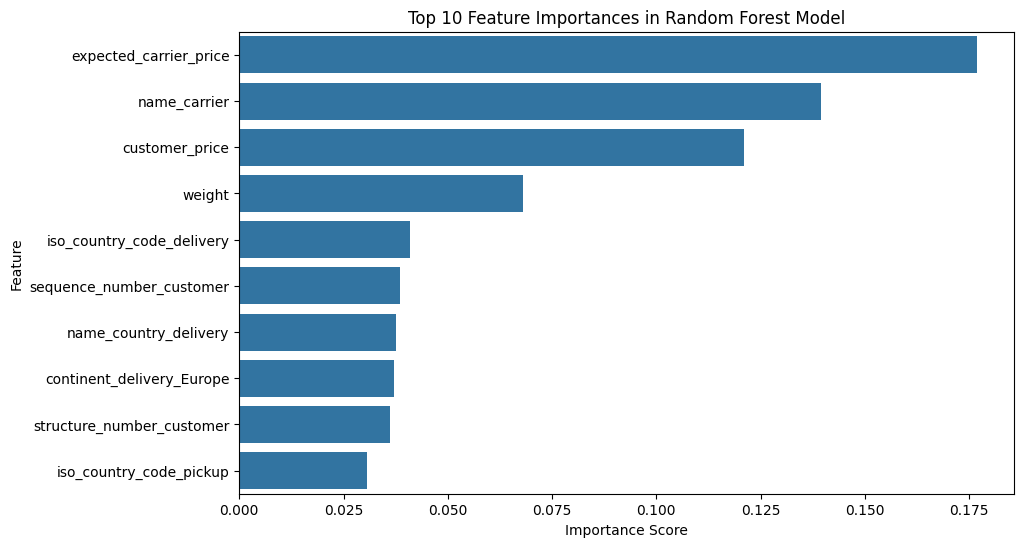

In [16]:
# Random Forest Feature Selection
# Train a RandomForestClassifier to determine feature importance
importance_rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduced number of estimators for simplicity
importance_rf.fit(X_train, y_train)

# Get Feature Importances and Select Important Features
feature_importances = pd.Series(importance_rf.feature_importances_, index=X_train.columns)
important_features = feature_importances[feature_importances > 0.01].index.tolist()  # Adjust threshold as needed

# Output the Selected Features
print("Selected Features:", important_features)

# Feature Importance Analysis (Top 10 from Selected Features)
selected_importances = feature_importances[important_features].sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_importances.values, y=selected_importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [17]:
# Create Final Dataset with Selected Features
X_selected_train = X_train[important_features]
X_selected_test = X_test[important_features]

# Model Training & Evaluation

Here we finally train and test different models to find the best ones.

We test the following models:
- Logistic Regression.
- Naive Bayes.
- Decision Tree.
- Random Forest.
- XGBoost.
- LightGBM.

Also, for each of the models:
1. We first apply the **K-Fold Cross Validation** (with k=5) to find the best model family.
2. We also train a model again for each of them, in order to compare different metrics for each of them when the model is trained on the whole training dataset.

The metrics we use are:
- Accuracy.
- Cross-Validation Accuracy
- Cross-Validation Standard Deviation.
- ROC-AUC.

In [37]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [18]:
# Prepare training and test data
X_train, X_test = X_selected_train, X_selected_test
y_train, y_test = y_train, y_test

In [19]:
# Label encoding for target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [40]:
# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Train the model on the whole training dataset this time
    model.fit(X_train, y_train_encoded)

    # Test set predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    class_report = classification_report(y_test_encoded, y_pred, output_dict=True, zero_division=0)
    confusion = confusion_matrix(y_test_encoded, y_pred)
    roc_auc = roc_auc_score(y_test_encoded, y_pred_prob, multi_class='ovr')

    # Store results
    results[model_name] = {
        "Accuracy": accuracy,
        "Cross-Validation Accuracy": cv_scores.mean(),
        "Cross-Validation Std Dev": cv_scores.std(),
        "Classification Report": class_report,
        "Confusion Matrix": confusion,
        "ROC AUC": roc_auc,
    }

    # Print metrics
    print(f"\nModel: {model_name}")
    print(f"Test Set Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion)
    print("\n" + "=" * 60 + "\n")


Training Logistic Regression...
Logistic Regression Cross-Validation Accuracy: 0.6520 (+/- 0.0014)

Model: Logistic Regression
Test Set Accuracy: 0.6477
ROC AUC: 0.8752
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.53      0.62     65152
           1       0.26      0.61      0.37      4251
           2       0.01      0.62      0.02        32
           3       0.11      0.83      0.20       260
           4       0.73      0.75      0.74     72474
           5       0.01      0.73      0.01        67

    accuracy                           0.65    142236
   macro avg       0.31      0.68      0.33    142236
weighted avg       0.72      0.65      0.67    142236

Confusion Matrix:
[[34679  4046   852   823 19848  4904]
 [  427  2590   265    86   713   170]
 [    0     6    20     4     0     2]
 [    2     4    32   216     0     6]
 [11713  3203   856   776 54576  1350]
 [    3     6     4     1     4    49]]



Training

In [41]:
# Display summary results
results_df = pd.DataFrame({
    model: {
        "Test Accuracy": metrics["Accuracy"],
        "Cross-Val Accuracy": metrics["Cross-Validation Accuracy"],
        "ROC AUC": metrics["ROC AUC"],
    }
    for model, metrics in results.items()
}).T

print("\nSummary of Results:")
print(results_df)


Summary of Results:
                     Test Accuracy  Cross-Val Accuracy   ROC AUC
Logistic Regression       0.647726            0.651978  0.875190
Naive Bayes               0.234955            0.248551  0.849070
Decision Tree             0.959813            0.958007  0.909619
Random Forest             0.975794            0.974550  0.996477
XGBoost                   0.963223            0.963823  0.997614
LightGBM                  0.946399            0.941417  0.966846


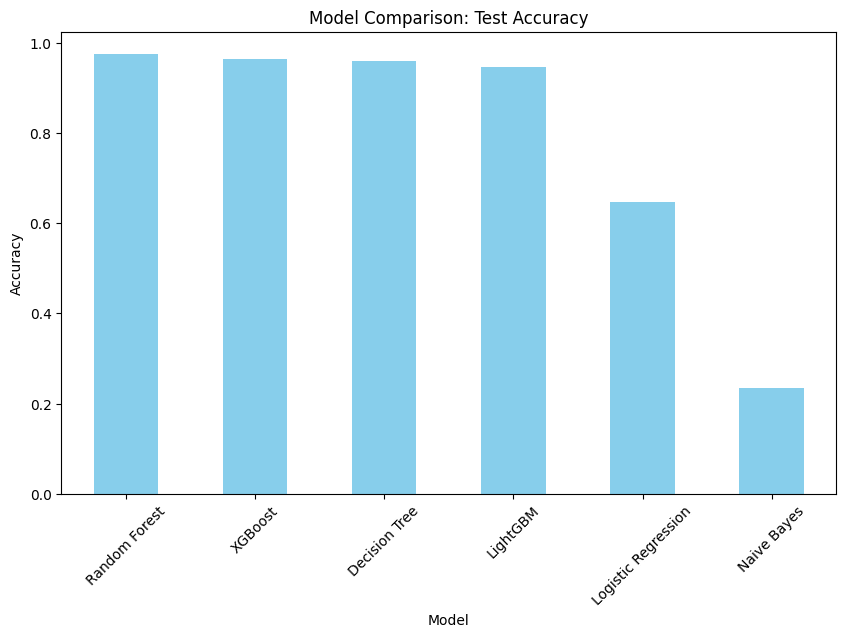

In [42]:
# Plot Test Accuracy for Comparison
plt.figure(figsize=(10, 6))
results_df["Test Accuracy"].sort_values(ascending=False).plot(kind="bar", color="skyblue")
plt.title("Model Comparison: Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.show()

# Analysis of Results

### Summary of Business Impact

The Random Forest model provides key insights for optimizing delivery services:
1. **Feature Importance**: The top features driving the predictions indicate which factors most impact the service type, providing insights into areas that can be optimized.
2. **Cost Matrix**: By analyzing the cost associated with false positives and false negatives, the model helps in understanding the financial implications of incorrect predictions. For example, reducing false positives might lower operational costs.
3. **Operational Efficiency**: By accurately predicting the service type, resources can be allocated more effectively, improving overall efficiency.
4. **Customer Targeting**: The insights from feature importance can help target specific customer segments with tailored services, increasing satisfaction and loyalty.

## Train best model

In [20]:
# Train the final Random Forest model
final_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
final_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_rf.predict(X_test)
y_pred_prob = final_rf.predict_proba(X_test)

## Compute metrics of performance

In [21]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
confusion = confusion_matrix(y_test, y_pred)
# Calculate ROC AUC for multiclass
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

## Cost Matrix

For this analysis, we assume the following:
- FN Cost: \$100 (missing a "Special" shipment is highly costly).
- FP Cost: \$10 (mislabeling a regular shipment as "Special" has moderate cost).
- TN/TP Cost: \$0 (correct predictions have no penalty).

The cost matrix emphasizes minimizing **false negatives** as missing a critical service type prediction can lead to significant operational or financial issues, while **false positives** cause minor inefficiencies. This approach aligns with business priorities to ensure service reliability.

In [22]:
# Updated Cost Matrix Analysis
cost_matrix = np.array([[0, 10],
                        [100, 0]])  # Costs: [[TN, FP], [FN, TP]]

# Calculate total cost from confusion matrix
cost = 0

for i in range(len(confusion)):
    for j in range(len(confusion)):
        cost += confusion[i, j] * cost_matrix[min(i, 1), min(j, 1)]  # Map confusion indices to cost matrix
print(f"Total Cost Based on Cost Matrix: {cost}")

Total Cost Based on Cost Matrix: 232690


In [23]:
# Cost Breakdown by Outcome
tn_cost = confusion[0, 0] * cost_matrix[0, 0]
fp_cost = confusion[0, 1] * cost_matrix[0, 1]
fn_cost = confusion[1, 0] * cost_matrix[1, 0]
tp_cost = confusion[1, 1] * cost_matrix[1, 1]

print(f"Cost Breakdown:")
print(f"True Negatives (TN): {tn_cost}")
print(f"False Positives (FP): {fp_cost}")
print(f"False Negatives (FN): {fn_cost}")
print(f"True Positives (TP): {tp_cost}")
print(f"Total Cost: {tn_cost + fp_cost + fn_cost + tp_cost}")

Cost Breakdown:
True Negatives (TN): 0
False Positives (FP): 20
False Negatives (FN): 1000
True Positives (TP): 0
Total Cost: 1020


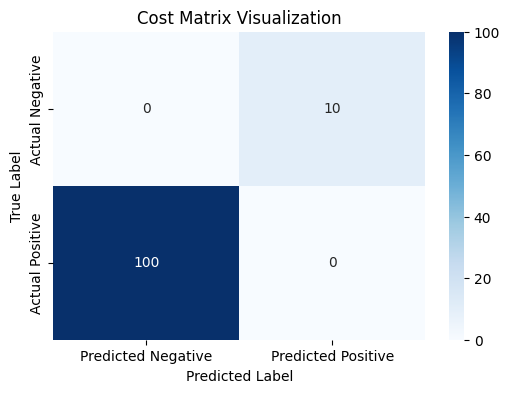

In [24]:
# Visualize the updated cost matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cost_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Cost Matrix Visualization')
plt.show()

## Tree visualization

In this section we can observe the decision rules from a single tree within our random forest model:

- We can view the decision rules with a max depth of 2, as with a depth of 3 we already have problems visualizing it

- We can view the leaf nodes of the tree and the decisions made to get to it

- We will observe common root nodes and class distribution in leaves

- We will analyze the most common paths for each class

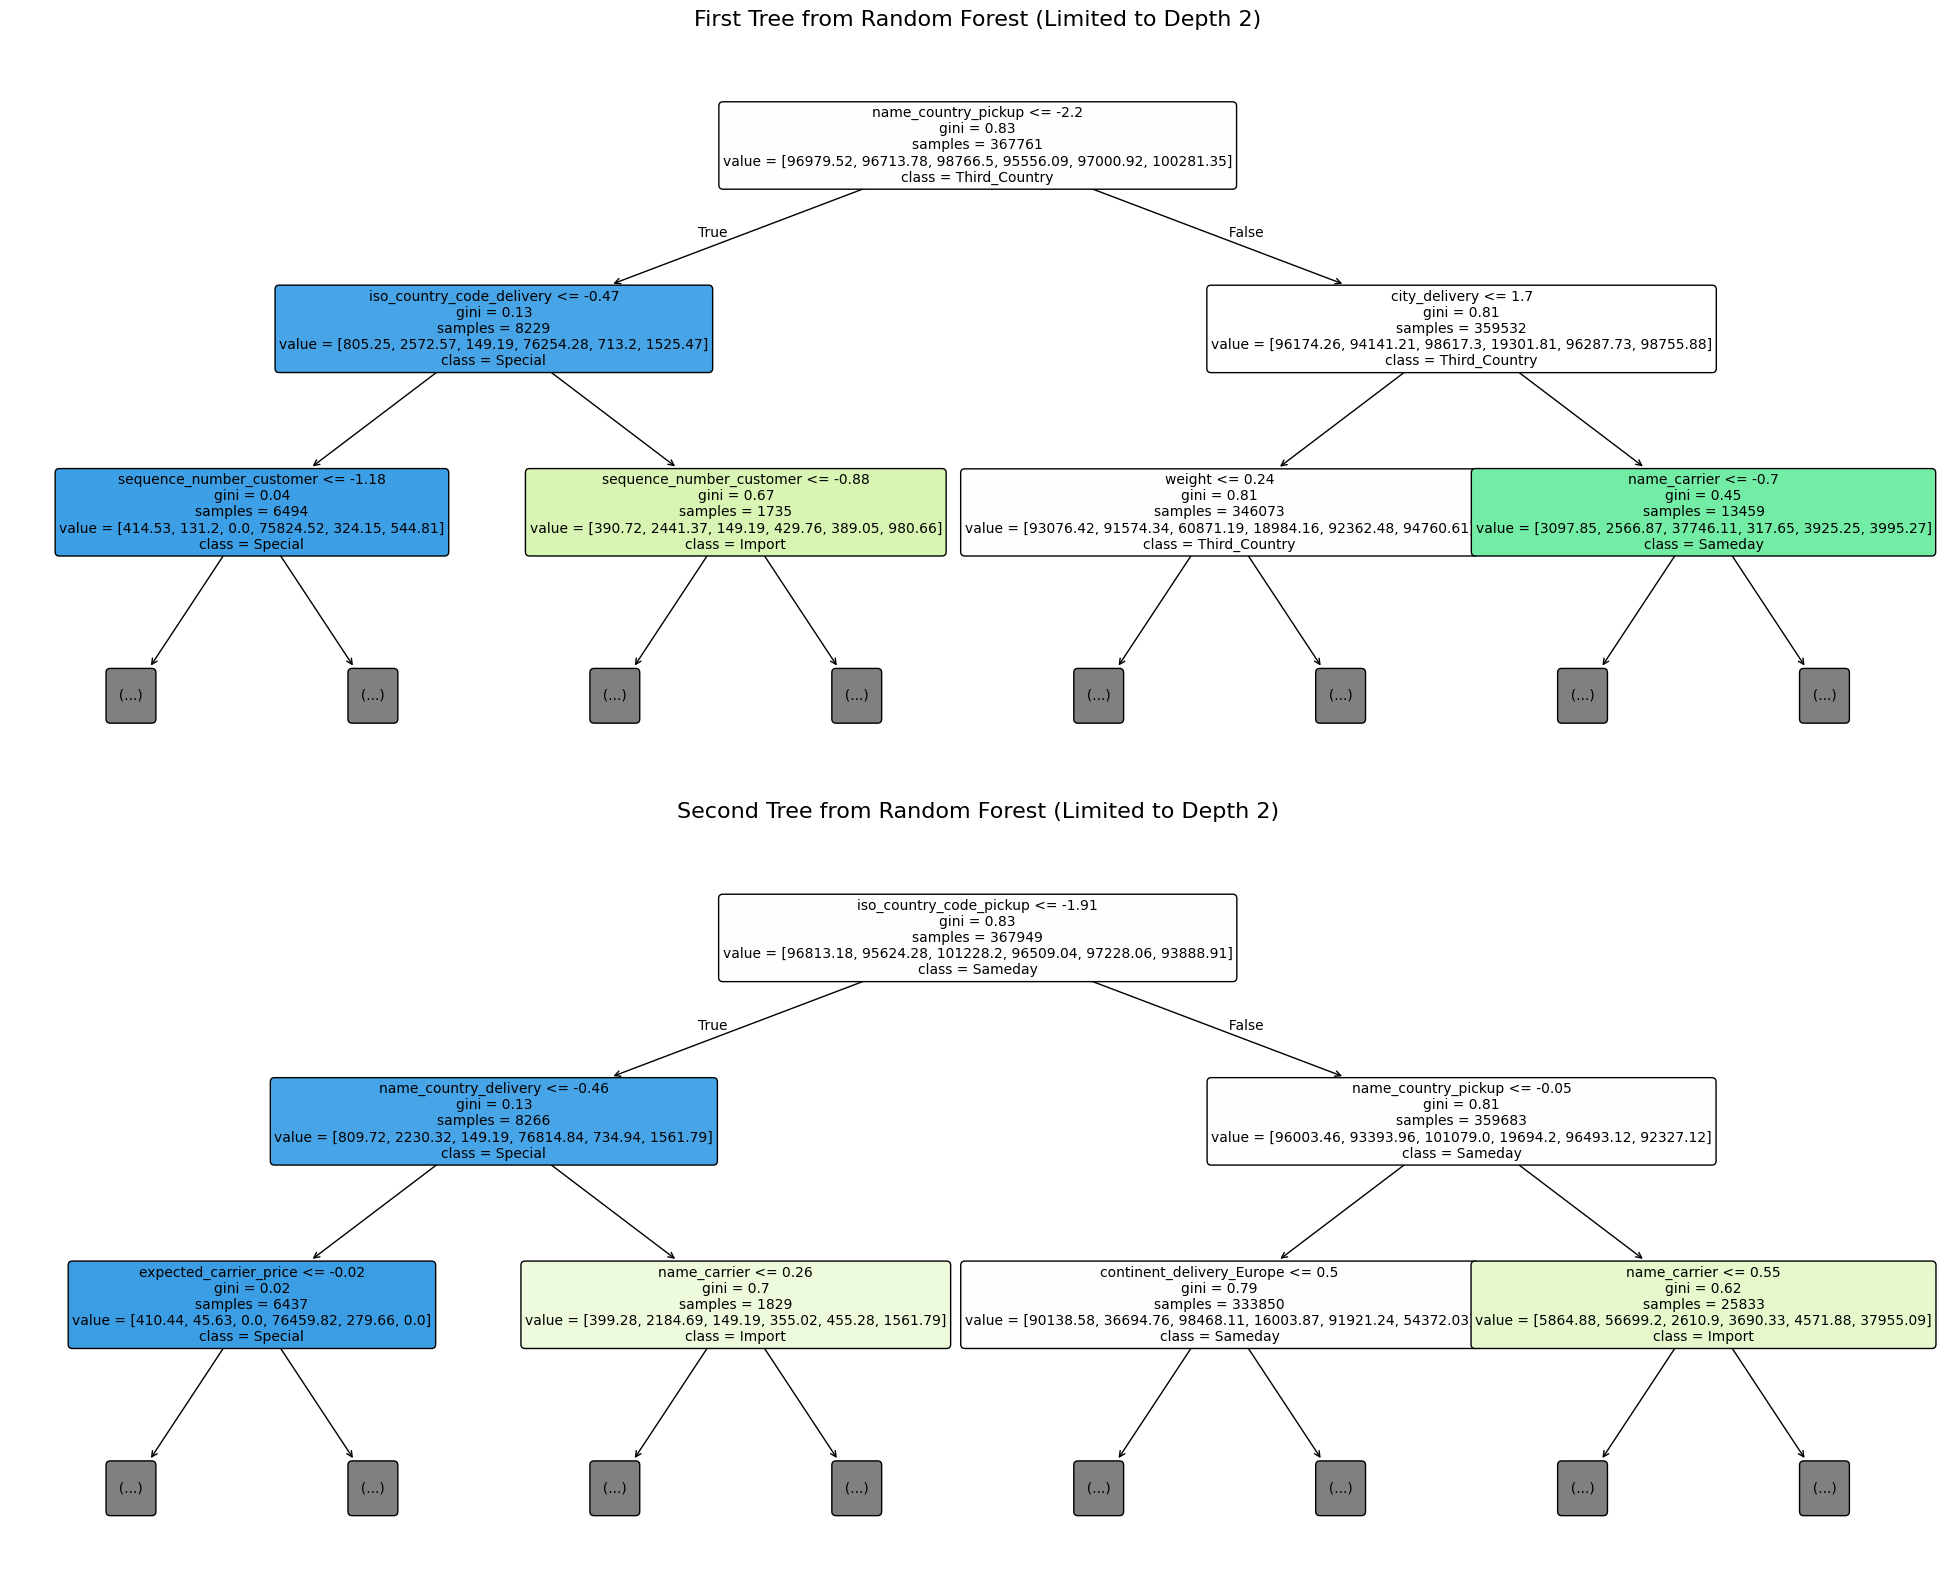


Decision Rules for First Tree:
--------------------------------------------------
Depth 1
If name_country_pickup <= -2.20:
Depth 2
If iso_country_code_delivery <= -0.47:
If iso_country_code_delivery > -0.47:
------------------------------
If name_country_pickup > -2.20:
Depth 2
If city_delivery <= 1.70:
If city_delivery > 1.70:
------------------------------
------------------------------

Decision Rules for Second Tree:
--------------------------------------------------
Depth 1
If iso_country_code_pickup <= -1.91:
Depth 2
If name_country_delivery <= -0.46:
If name_country_delivery > -0.46:
------------------------------
If iso_country_code_pickup > -1.91:
Depth 2
If name_country_pickup <= -0.05:
If name_country_pickup > -0.05:
------------------------------
------------------------------


In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Analyze two trees from the random forest
tree1 = final_rf.estimators_[0]  # First tree
tree2 = final_rf.estimators_[1]  # Second tree
tree1_ = tree1.tree_
tree2_ = tree2.tree_

# Visualize both tree structures
plt.figure(figsize=(20, 16))

# Plot first tree
plt.subplot(2, 1, 1)
plot_tree(tree1,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("First Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

# Plot second tree
plt.subplot(2, 1, 2)
plot_tree(tree2,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("Second Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# Print decision rules for both trees
def print_rules(node, depth, path, tree_, X_train):
    if depth > 2:
        return
        
    if tree_.children_left[node] != tree_.children_right[node]:  # internal node
        name = X_train.columns[tree_.feature[node]]
        threshold_val = tree_.threshold[node]
        print("Depth", depth)
        print(f"If {name} <= {threshold_val:.2f}:")
        print_rules(tree_.children_left[node], depth + 1, path + [f"{name} <= {threshold_val:.2f}"], tree_, X_train)
        print(f"If {name} > {threshold_val:.2f}:")
        print_rules(tree_.children_right[node], depth + 1, path + [f"{name} > {threshold_val:.2f}"], tree_, X_train)
        print("-" * 30)

print("\nDecision Rules for First Tree:")
print("-" * 50)
print_rules(0, 1, [], tree1_, X_train)

print("\nDecision Rules for Second Tree:")
print("-" * 50)
print_rules(0, 1, [], tree2_, X_train)


In the next cell, we are going to look at 5 sample nodes from each tree, from root to leaf node.

In [26]:
# Function to print leaf nodes for a specific tree
def print_leaves(node, path, tree_, X_train, final_rf, leaves_printed):
    if leaves_printed[0] >= 5:
        return
        
    if tree_.feature[node] == -2:  # leaf node
        predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
        n_samples = tree_.n_node_samples[node]
        print(f"\nLeaf Node {leaves_printed[0] + 1}:")
        print(f"Decision Path: {' AND '.join(path)}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Number of samples in leaf: {n_samples}")
        print("-" * 50)
        leaves_printed[0] += 1
        return
        
    name = X_train.columns[tree_.feature[node]]
    threshold = tree_.threshold[node]
    
    print_leaves(tree_.children_left[node], path + [f"{name} <= {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)
    if leaves_printed[0] < 5:
        print_leaves(tree_.children_right[node], path + [f"{name} > {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)

# Print sample leaf nodes for both trees
print("\nSample of 5 Leaf Nodes from First Tree:")
print("=" * 50)
leaves_printed1 = [0]  # Using list to make it mutable
print_leaves(0, [], tree1_, X_train, final_rf, leaves_printed1)

print("\nSample of 5 Leaf Nodes from Second Tree:")
print("=" * 50)
leaves_printed2 = [0]  # Using list to make it mutable
print_leaves(0, [], tree2_, X_train, final_rf, leaves_printed2)


Sample of 5 Leaf Nodes from First Tree:

Leaf Node 1:
Decision Path: name_country_pickup <= -2.20 AND iso_country_code_delivery <= -0.47 AND sequence_number_customer <= -1.18 AND name_country_pickup <= -2.28
Predicted Class: Import
Number of samples in leaf: 7
--------------------------------------------------

Leaf Node 2:
Decision Path: name_country_pickup <= -2.20 AND iso_country_code_delivery <= -0.47 AND sequence_number_customer <= -1.18 AND name_country_pickup > -2.28 AND name_carrier <= 0.55 AND customer_price <= -0.21 AND sequence_number_customer <= -1.18 AND iso_country_code_delivery <= -0.98 AND shipment_type_Parcel <= 0.50
Predicted Class: Standard
Number of samples in leaf: 1
--------------------------------------------------

Leaf Node 3:
Decision Path: name_country_pickup <= -2.20 AND iso_country_code_delivery <= -0.47 AND sequence_number_customer <= -1.18 AND name_country_pickup > -2.28 AND name_carrier <= 0.55 AND customer_price <= -0.21 AND sequence_number_customer <=

By analyzing them, we have the following insights:
- Geographic Patterns:


  - Primary splits often based on pickup country (name_country_pickup, iso_country_code_pickup)
  - Location codes (postal codes, country codes) heavily influence service type choice

- Customer Characteristics:
  - Customer sequence numbers below -1.18 indicate distinct service preferences
  - Customer structure numbers and IDs influence routing decisions


- Price-Based Rules:
  - Lower customer prices (≤ -0.21) often lead to Standard service
  - Higher expected carrier prices influence routing to Express service
  - Price thresholds vary by geographic region

- Service Selection:
  - Parcel shipments have different rules (seen in first tree)
  - Express is more common with higher customer prices and specific postal code ranges
  - Import class is chosen based on specific country code combinations

In the following cell, we are going to analyze the most common root features and the class distribution in leaves.

In [ ]:
n_trees = 100

# Initialize counters for pattern analysis
feature_at_root = {}    # Features used at root node
common_paths = {}       # Common decision paths leading to each class
class_distributions = {} # Distribution of predicted classes per tree
avg_depth = 0          # Average tree depth

# Analyze patterns across specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_
    
    # Count root feature
    root_feature = X_train.columns[tree_.feature[0]]
    feature_at_root[root_feature] = feature_at_root.get(root_feature, 0) + 1
    
    # Analyze class distribution in leaves
    leaves_mask = tree_.feature == -2
    leaf_classes = [final_rf.classes_[np.argmax(tree_.value[i][0])] 
                   for i in range(len(tree_.feature)) if leaves_mask[i]]
    
    for class_name in leaf_classes:
        class_distributions[class_name] = class_distributions.get(class_name, 0) + 1
        
    # Calculate tree depth
    avg_depth += tree_.max_depth

avg_depth /= n_trees

# Print analysis results
print(f"\nAnalysis of {n_trees} trees:")
print("\nMost Common Root Features:")
for feature, count in sorted(feature_at_root.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {count} trees ({count/n_trees*100:.1f}%)")

print("\nClass Distribution in Leaves:")
total_leaves = sum(class_distributions.values())
for class_name, count in sorted(class_distributions.items(), key=lambda x: x[1], reverse=True):
    print(f"{class_name}: {count} leaves ({count/total_leaves*100:.1f}%)")

print(f"\nAverage Tree Depth: {avg_depth:.1f}")


Analysis of 100 trees:

Most Common Root Features:
name_country_pickup: 21 trees (21.0%)
name_country_delivery: 18 trees (18.0%)
weight: 15 trees (15.0%)
iso_country_code_pickup: 14 trees (14.0%)
iso_country_code_delivery: 9 trees (9.0%)
expected_carrier_price: 7 trees (7.0%)
structure_number_customer: 6 trees (6.0%)
sequence_number_customer: 4 trees (4.0%)
customer_price: 4 trees (4.0%)
customer_id: 1 trees (1.0%)
name_carrier: 1 trees (1.0%)

Class Distribution in Leaves:
Standard: 1250980 leaves (50.1%)
Express: 1163923 leaves (46.6%)
Import: 40237 leaves (1.6%)
Special: 24871 leaves (1.0%)
Third_Country: 10115 leaves (0.4%)
Sameday: 8505 leaves (0.3%)

Average Tree Depth: 45.3


By analyzing them, we have the following insights:
- Location is the primary decision factor, with 62% of trees starting with geographic features

- Weight is a significant factor (15% of root nodes)
- Standard and Express services dominate (96.7% of all leaf nodes)


In the following cell we are going to view the most common paths of 100 trees in relation to the class.

In [ ]:
n_trees = 100
max_paths_per_class = 3

# Dictionary to store paths for each class
class_paths = {class_name: [] for class_name in final_rf.classes_}

# Analyze paths in specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_
    
    # Define path extraction for current tree
    def extract_paths(node, path):
        # If leaf node, store the path
        if tree_.feature[node] == -2:
            predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
            class_paths[predicted_class].append((path, tree_.n_node_samples[node]))
            return
            
        # Get feature name and threshold
        feature = X_train.columns[tree_.feature[node]]
        threshold = tree_.threshold[node]
        
        # Recurse left
        left_path = path + [(feature, '<=', threshold)]
        extract_paths(tree_.children_left[node], left_path)
        
        # Recurse right
        right_path = path + [(feature, '>', threshold)]
        extract_paths(tree_.children_right[node], right_path)
    
    # Extract paths from current tree
    extract_paths(0, [])

# Print analysis results
print(f"\nAnalysis of Common Paths in {n_trees} trees:")
for class_name in final_rf.classes_:
    print(f"\nClass: {class_name}")
    print("=" * 50)
    
    # Count identical paths
    path_counts = {}
    for path, samples in class_paths[class_name]:
        path_str = ' AND '.join([f"{feat} {op} {val:.2f}" for feat, op, val in path])
        path_counts[path_str] = path_counts.get(path_str, 0) + samples
    
    # Sort and display most common paths
    sorted_paths = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)
    for path, count in sorted_paths[:max_paths_per_class]:
        print(f"\nDecision Path (samples: {count}):")
        print(path)
        print("-" * 30)


Analysis of Common Paths in 100 trees:

Class: Express

Decision Path (samples: 20600):
structure_number_customer > -1.06 AND continent_delivery_Asia <= 0.50 AND name_carrier > 0.55 AND iso_country_code_pickup <= 0.43 AND EU_pickup > -6.20 AND iso_country_code_delivery <= 2.50 AND domain_name_DE > 0.50 AND iso_country_code_pickup <= -0.22 AND EU_delivery > -1.18 AND segmentation_customer <= 0.66 AND customer_price > -0.23 AND name_carrier <= 0.62 AND name_country_delivery > -0.36 AND name_country_pickup > -0.40 AND name_country_delivery <= -0.25 AND customer_price <= 1.91 AND expected_carrier_price <= 1.23 AND postal_code_pickup > -1.70
------------------------------

Decision Path (samples: 18558):
weight <= 0.07 AND expected_carrier_price <= -0.00 AND iso_country_code_pickup <= 0.43 AND name_carrier <= 0.66 AND domain_name_pickup_FR > 0.50 AND name_country_delivery <= -0.34 AND customer_price <= -0.12 AND name_country_delivery > -0.44 AND city_pickup > -1.14 AND structure_number_cus

Based on the path analysis, we can view some patterns learned by the model:

- Service Type Decision Rules:

  - Express: Primarily determined by EU locations, moderate prices, and specific carrier combinations
  
  - Import: Triggered by cross-continental shipments, moderate weights, and specific country code patterns
  
  - Sameday: Requires higher customer prices (>0.96), specific city locations, and often no insurance
  
  - Special: Associated with specific delivery codes, customer sequence numbers, and weight thresholds
 
  - Standard: Characterized by moderate prices, parcel shipments, and specific carrier-location combinations
 
  - Third_Country: Almost exclusively based on Asian pickup locations and non-EU deliveries

- Common Decision Factors:

  - Geographic features dominate initial decisions (country codes, EU status)
  
  - Price thresholds vary by service type
  
  - Customer characteristics (sequence numbers, segmentation) provide fine-tuning
  
  - Weight plays a role in most service type decisions

## Feature importance

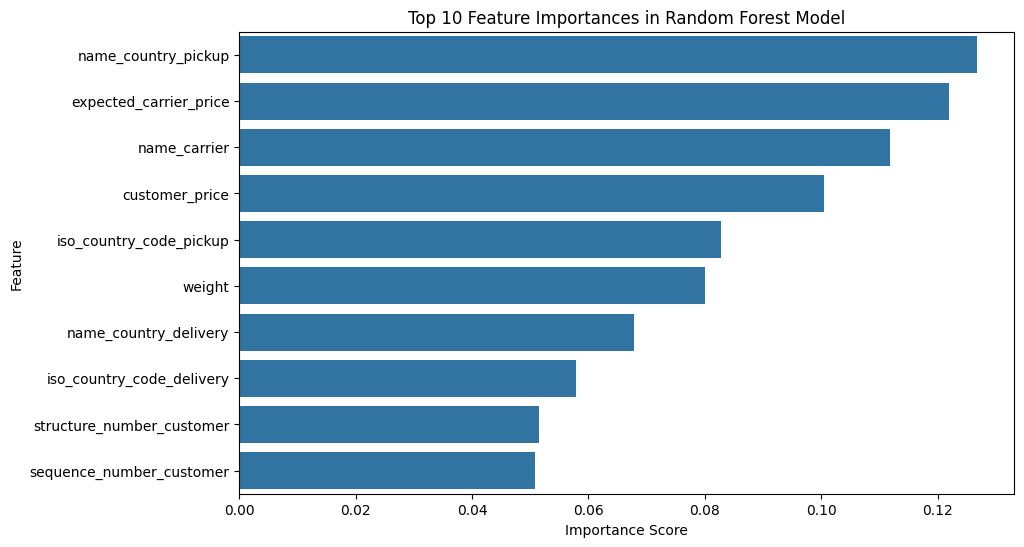

In [48]:
# Feature Importance Analysis
importances = pd.Series(final_rf.feature_importances_, index=X_selected_train.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Top 10 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Business Interpretation

In [49]:
print("\nBusiness Interpretation of Results:")
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:")
for label, metrics in class_report.items():
    if isinstance(metrics, dict):
        print(f"{label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}")


Business Interpretation of Results:
Test Set Accuracy: 0.9758
ROC AUC: 0.9965
Classification Report:
Express: Precision=0.97, Recall=0.98, F1-score=0.97
Import: Precision=1.00, Recall=1.00, F1-score=1.00
Sameday: Precision=0.83, Recall=0.59, F1-score=0.69
Special: Precision=0.94, Recall=0.92, F1-score=0.93
Standard: Precision=0.98, Recall=0.97, F1-score=0.98
Third_Country: Precision=0.98, Recall=0.76, F1-score=0.86
macro avg: Precision=0.95, Recall=0.87, F1-score=0.90
weighted avg: Precision=0.98, Recall=0.98, F1-score=0.98


For the model analysis, we also have these recommendations:

- Geographic Service Optimization: location is the primary driver with over 62% of root decisions, and ech region has distinct service preferences. Our recommendation would be tailoring service offerings by region and optimizing carrier partnerships accordingly.

- Customer Segmentation Strategy: the customer structure and sequence numbers strongly influence service choice, with different segments showing distinct service preferences. Our recommendation would be developing targeted service packages for different customer segments.